## Final Project Submission

Please fill out:
* Student name: Levi Raichik
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:


# Table of Contents

- [Import Libraries](#Import-Libraries)
- [Functions](#Functions)
- [Load in Dataset](#Load-in-Dataset)
- [Checkout the data](#Checkout-the-data)
- [Balancing out the dataset](#Balancing-out-the-dataset)
    - [Using SMOTE to balance out the dataset](#Using-SMOTE-to-balance-out-the-dataset)  
- [Going into Random forests more to see how it can best be optimized](#Going-into-Random-forests-more-to-see-how-it-can-best-be-optimized)
    - [Trying with balanced bagging](#Trying-with-balanced-bagging)
    - [Regular bagging with the smoted data](#Regular-bagging-with-the-smoted-data)
    - [Cross val with smoted data](#Cross-val-with-smoted-data)
- [Checking feature importance](#Checking-feature-importance)
- [XbBoost](#XbBoost)
- [Looking further into feature importance](#Looking-further-into-feature-importance)
- [Final Model](#Final-Model)
- [Recommendations](#Recommendations)
- [Further Work](#Further-Work)

## Import Libraries

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

[Return to contents](#Table-of-Contents)

## Functions

In [441]:
def cm(y_real, y_pred, t='test'):
    cf = confusion_matrix(y_real, y_pred)
    print(f"Confusion Matrix {t}: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf/(np.sum(cf)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [292]:
def cost_benefit(y_true, y_pred, promo = 500, income24m = 60*24):
    m = confusion_matrix(y_true, y_pred)
    FP = m[0][1]*promo
    FN = m[1][0]*income24m
    TP = m[1][1]*(income24m-promo)
    return TP - (FP+FN)

## Load in Dataset

In [3]:
df = pd.read_csv('churn.csv')
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


[Return to contents](#Table-of-Contents)

## Checkout the data

General Stats

In [4]:
df.describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,25.99840,100.25860,436.911400,2499.500000,0.094600,0.264600,7.755200,180.288900,100.029400,30.649668,...,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400,0.141400
std,14.80348,39.69456,42.209182,1443.520003,0.292691,0.441164,13.546393,53.894699,19.831197,9.162069,...,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363,0.348469
min,0.00000,1.00000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.00000,73.00000,408.000000,1249.750000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,...,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.00000,100.00000,415.000000,2499.500000,0.000000,0.000000,0.000000,180.100000,100.000000,30.620000,...,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,39.00000,127.00000,415.000000,3749.250000,0.000000,1.000000,17.000000,216.200000,113.000000,36.750000,...,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,50.00000,243.00000,510.000000,4999.000000,1.000000,1.000000,52.000000,351.500000,165.000000,59.760000,...,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [5]:
df.loc[df['class'] == 1].describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,...,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.0
mean,26.251768,102.332390,437.971711,2543.499293,0.281471,0.144272,4.496464,207.870580,100.817539,35.338416,...,99.884017,17.999562,206.078218,99.575672,9.273607,10.692362,4.151344,2.887426,2.254597,1.0
std,14.228766,39.396993,42.848131,1425.252780,0.450035,0.351614,11.297719,68.576475,20.757110,11.658195,...,19.618258,4.383293,49.685763,19.968555,2.235902,2.793187,2.550011,0.754057,1.815956,0.0
min,0.000000,1.000000,408.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.000000,6.030000,47.400000,42.000000,2.130000,0.000000,0.000000,0.000000,0.000000,1.0
25%,15.000000,76.000000,411.500000,1310.500000,0.000000,0.000000,0.000000,153.500000,88.000000,26.095000,...,86.500000,14.945000,171.750000,85.000000,7.730000,8.800000,2.000000,2.380000,1.000000,1.0
50%,26.000000,102.000000,415.000000,2576.000000,0.000000,0.000000,0.000000,215.900000,101.000000,36.700000,...,99.000000,17.940000,206.300000,100.000000,9.280000,10.600000,4.000000,2.860000,2.000000,1.0
75%,38.000000,126.500000,510.000000,3770.000000,1.000000,0.000000,0.000000,266.450000,115.000000,45.295000,...,113.500000,21.190000,240.850000,114.000000,10.840000,12.800000,5.000000,3.460000,4.000000,1.0
max,50.000000,225.000000,510.000000,4985.000000,1.000000,1.000000,48.000000,351.500000,165.000000,59.760000,...,168.000000,30.910000,381.600000,158.000000,17.170000,20.000000,20.000000,5.400000,9.000000,1.0


In [6]:
df.loc[df['class'] == 0].describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,...,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.0
mean,25.956674,99.917074,436.736781,2492.253902,0.063825,0.284416,8.291870,175.746564,99.899604,29.877494,...,100.241556,16.898654,199.455113,99.975775,8.975593,10.190869,4.481947,2.752055,1.457722,0.0
std,14.897193,39.737531,42.105520,1446.542156,0.244469,0.451189,13.809408,49.634575,19.674019,8.437810,...,19.862391,4.262900,50.609570,19.958820,2.277438,2.749994,2.438233,0.742443,1.164236,0.0
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,13.000000,73.000000,408.000000,1240.000000,0.000000,0.000000,0.000000,142.900000,87.000000,24.290000,...,87.000000,13.980000,165.900000,87.000000,7.470000,8.500000,3.000000,2.300000,1.000000,0.0
50%,26.000000,99.000000,415.000000,2485.000000,0.000000,0.000000,0.000000,178.000000,100.000000,30.260000,...,101.000000,16.960000,199.000000,100.000000,8.960000,10.300000,4.000000,2.780000,1.000000,0.0
75%,39.000000,127.000000,415.000000,3746.000000,0.000000,1.000000,20.000000,210.700000,113.000000,35.820000,...,114.000000,19.750000,233.400000,113.000000,10.500000,12.000000,6.000000,3.240000,2.000000,0.0
max,50.000000,243.000000,510.000000,4999.000000,1.000000,1.000000,52.000000,315.600000,163.000000,53.650000,...,170.000000,30.750000,395.000000,175.000000,17.770000,19.700000,19.000000,5.320000,8.000000,0.0


Seeing what the columns are and if there are any null values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null int64
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null int64
international_plan               5000 non-null int64
voice_mail_plan                  5000 non-null int64
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes               

Checking the general distributions of the features

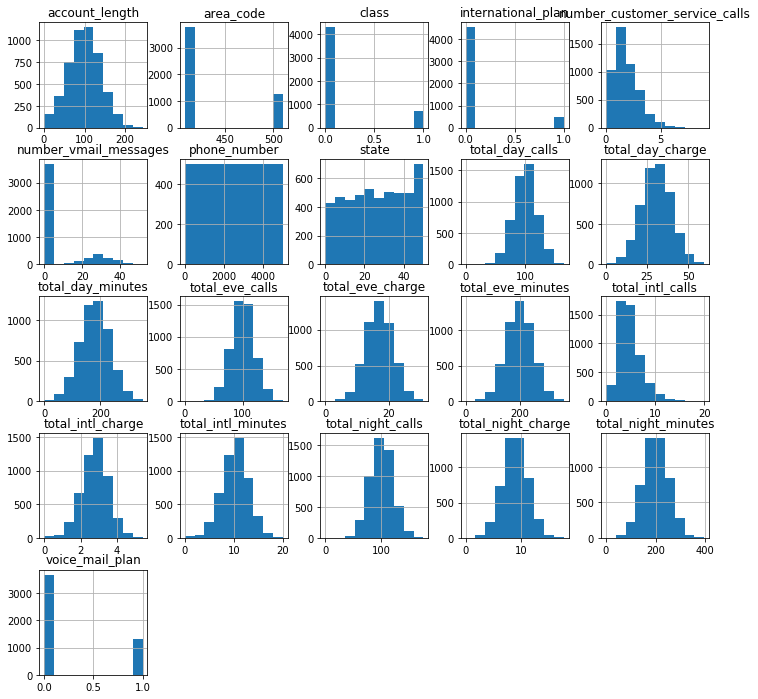

In [8]:
df.hist(figsize=(12,12));

Notice that we have very few cancellation customers. 

In [9]:
df['class'].value_counts()

0    4293
1     707
Name: class, dtype: int64

Checking out a correlation matrix of the data

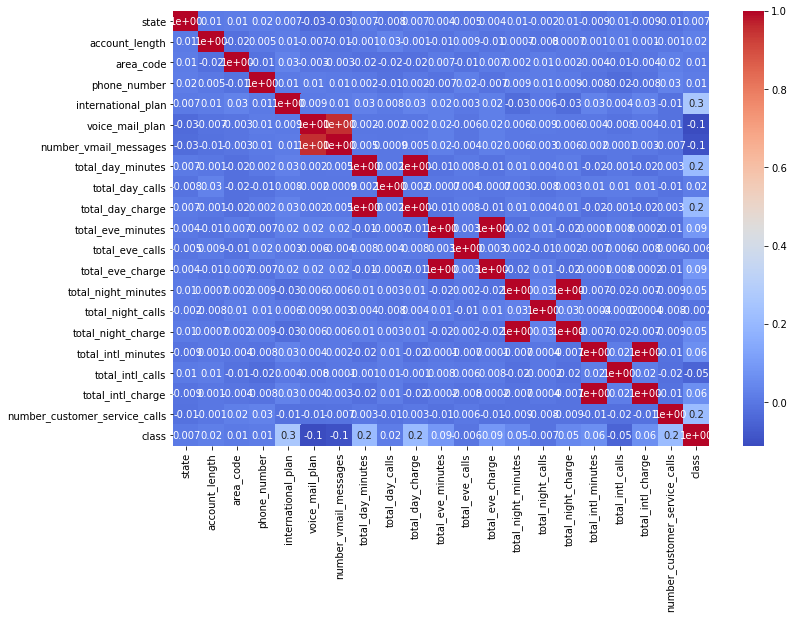

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1');

Notice how minutes and charges are very correlated

Checkout how many unique values there are for each feature

In [11]:
for col in df.columns:
    print(f'\n{col}')
    print(len(df[col].unique()))


state
51

account_length
218

area_code
3

phone_number
5000

international_plan
2

voice_mail_plan
2

number_vmail_messages
48

total_day_minutes
1961

total_day_calls
123

total_day_charge
1961

total_eve_minutes
1879

total_eve_calls
126

total_eve_charge
1659

total_night_minutes
1853

total_night_calls
131

total_night_charge
1028

total_intl_minutes
170

total_intl_calls
21

total_intl_charge
170

number_customer_service_calls
10

class
2


I will drop phone numbers as each one is different anyway

In [12]:
df = df.drop(['phone_number'], axis=1)
df.head(1)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0


[Return to contents](#Table-of-Contents)

## Balancing out the dataset

First splitting the data

In [13]:
X = df.drop(['class'], axis=1)
y = df['class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

Checking to make sure there are enough cancellation customers in the train and test split

In [15]:
y_test.value_counts()

0    861
1    139
Name: class, dtype: int64

In [16]:
y_train.value_counts()

0    3432
1     568
Name: class, dtype: int64

Seems to be fine

### Using SMOTE to balance out the dataset

In [17]:
sm = SMOTE(n_jobs=-1)

In [18]:
X_train_smoted, y_train_smoted = sm.fit_sample(X_train, y_train)

Try it with a baseline random forest

In [19]:
rf = RandomForestClassifier()

In [20]:
rf.fit(X_train_smoted, y_train_smoted)

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
train_pred = rf.predict(X_train)
train_pred_smoted = rf.predict(X_train_smoted)
test_pred = rf.predict(X_test)

Confusion Matrix test: 


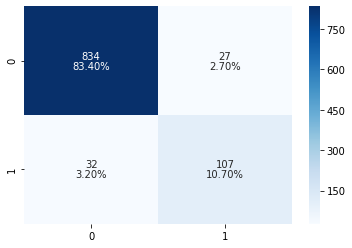

In [22]:
cm(y_test, test_pred)

Confusion Matrix train: 


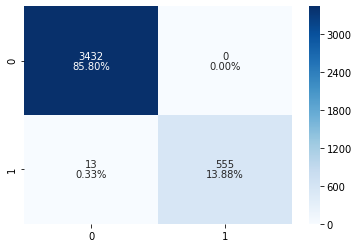

In [23]:
cm(y_train, train_pred, t='train')

Confusion Matrix train_smoted: 


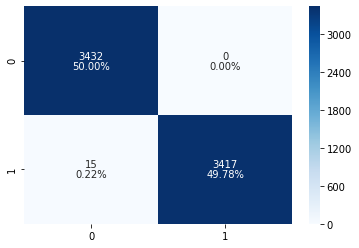

In [24]:
cm(y_train_smoted, train_pred_smoted, t='train_smoted')

Just playing with the probs a bit to see what I can change

In [25]:
test_predprobs = rf.predict_proba(X_test)

In [26]:
probs = []
for x in test_predprobs:
    if x[0] >= .65:
        probs.append(0)
    else:
        probs.append(1)   
        

Confusion Matrix test: 


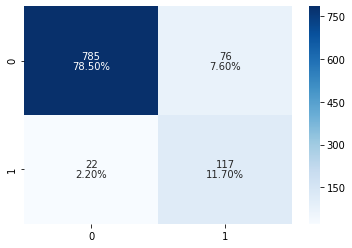

In [27]:
cm(y_test, probs, t='test')

In [28]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       861
           1       0.80      0.77      0.78       139

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.94      0.94      0.94      1000



[Return to contents](#Table-of-Contents)

## Going into Random forests more to see how it can best be optimized

GridsearchCV

In [29]:
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [10, 11, 12, 15],
    "min_impurity_decrease": [.0001, .001, .01]
}
gs_tree = GridSearchCV(clf, param_grid, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_tree.fit(X_train_smoted, y_train_smoted)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [10, 11, 12, 15], 'min_impurity_decrease': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [30]:
rf_gs = pd.DataFrame(gs_tree.cv_results_)
rf_gs.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.053201,0.002924,0.005600,0.002058,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.677739,0.065296,270,0.723497,0.776685,0.626001,0.688274,0.635106,0.689913,0.056122
1,0.251398,0.018931,0.013802,0.003188,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.706876,0.038055,259,0.810929,0.705282,0.587764,0.749818,0.691916,0.709142,0.073565
2,0.456001,0.018226,0.021995,0.001099,gini,1,0.0001,10,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.736597,0.102230,226,0.701639,0.751913,0.805171,0.666788,0.782229,0.741548,0.050975
3,0.052596,0.006213,0.003802,0.000401,gini,1,0.0001,11,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.568765,0.118021,287,0.646266,0.673953,0.657320,0.385652,0.620539,0.596746,0.106966
4,0.225796,0.007983,0.011801,0.000402,gini,1,0.0001,11,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.725816,0.078008,240,0.717304,0.805100,0.726147,0.682447,0.697014,0.725603,0.042588


In [31]:
rf_gs.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
261,0.214999,0.006258,0.004999,0.000001,entropy,10,0.0001,15,10,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.920163,0.049276,1,0.953005,0.920583,0.924982,0.921340,0.936635,0.931309,0.012277
257,2.189596,0.037184,0.032401,0.000489,entropy,10,0.0001,11,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.919872,0.049764,2,0.956284,0.931148,0.928259,0.933358,0.935543,0.936918,0.009979
269,2.287999,0.132800,0.033401,0.002869,entropy,10,0.001,11,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.918706,0.052890,3,0.952277,0.932240,0.925710,0.929352,0.933358,0.934587,0.009232
253,1.139798,0.030558,0.016800,0.000750,entropy,10,0.0001,10,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.918415,0.050549,4,0.959563,0.930055,0.928623,0.932265,0.933722,0.936846,0.011494
109,0.805594,0.025137,0.017799,0.001167,gini,10,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,0.918415,0.049171,4,0.955191,0.931148,0.932629,0.931901,0.932629,0.936700,0.009262


In [32]:
gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_samples_leaf': 15,
 'n_estimators': 10}

In [304]:
rf2 = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=10, min_impurity_decrease=.0001, min_samples_leaf=15)
rf2.fit(X_train_smoted, y_train_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [305]:
train_pred2 = rf2.predict(X_train)
train_pred_smoted2 = rf2.predict(X_train_smoted)
test_pred2 = rf2.predict(X_test)

Confusion Matrix test: 


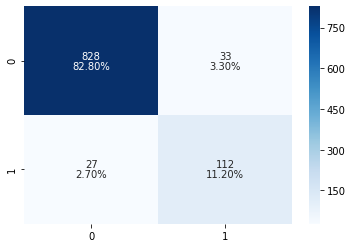

In [306]:
cm(y_test, test_pred2)

Check the FN to see more about them

In [36]:
indices = []
for i, true, pred in zip(y_test.index, y_test.values, test_pred2):
    if pred == 0 and true == 1:
        indices.append(i)

In [37]:
print(indices)

[2377, 4257, 84, 3601, 2819, 2575, 4624, 2357, 4996, 3382, 1534, 2405, 4112, 1965, 4324, 1115, 2934, 3439, 3409, 1746, 1718, 4210, 2925]


(array([4., 9., 2., 1., 1., 1., 0., 0., 0., 5.]),
 array([0.01717905, 0.06520755, 0.11323604, 0.16126453, 0.20929302,
        0.25732151, 0.30535001, 0.3533785 , 0.40140699, 0.44943548,
        0.49746397]),
 <a list of 10 Patch objects>)

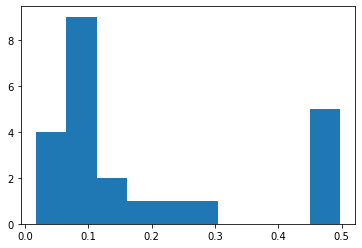

In [38]:
plt.hist(rf2.predict_proba(X.loc[indices])[:, 1])

Change probs

In [39]:
fn_probs = rf2.predict_proba(X.loc[indices])[:, 1]

In [41]:
print(sorted(fn_probs))

[0.01717905478986703, 0.050974589844479896, 0.061392147587721234, 0.063790175757733, 0.07847630219964169, 0.07988649373854179, 0.08157014126307713, 0.08962140208460388, 0.10519252546571152, 0.10763938326823771, 0.10892026612950606, 0.11215646714062487, 0.11312251271809708, 0.12587765527355635, 0.129355530652698, 0.17363919994527457, 0.23670269322396537, 0.28525443205802536, 0.4679162712791374, 0.47845441965042373, 0.4802230972090848, 0.48602715123175677, 0.4974639730882264]


In [309]:
probs = []
for i in rf2.predict_proba(X_test):
    if i[1] >=.42:
        probs.append(1)
    else:
        probs.append(0)

Confusion Matrix test: 


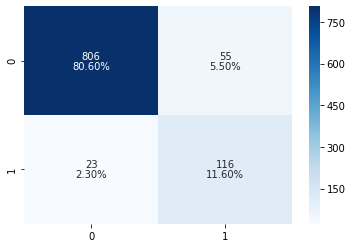

In [310]:
cm(y_test, probs)

Confusion Matrix train: 


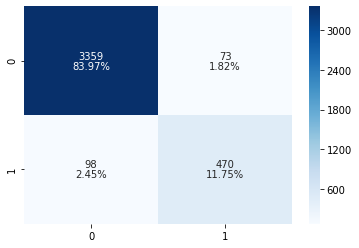

In [311]:
cm(y_train, train_pred2, t='train')

Confusion Matrix train_smoted: 


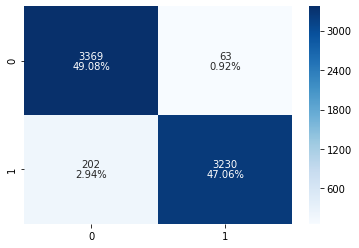

In [45]:
cm(y_train_smoted, train_pred_smoted2, t='train_smoted')

In [307]:
print(classification_report(y_test, test_pred2))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       861
           1       0.77      0.81      0.79       139

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.87      0.88      0.88      1000
weighted avg       0.94      0.94      0.94      1000



In [312]:
print(classification_report(y_train, train_pred2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3432
           1       0.87      0.83      0.85       568

   micro avg       0.96      0.96      0.96      4000
   macro avg       0.92      0.90      0.91      4000
weighted avg       0.96      0.96      0.96      4000



In [313]:
print(classification_report(y_test, probs))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       861
           1       0.68      0.83      0.75       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.83      0.89      0.85      1000
weighted avg       0.93      0.92      0.93      1000



[Return to contents](#Table-of-Contents)

### Trying with balanced bagging

In [67]:
bag = BalancedBaggingClassifier(base_estimator=rf2, verbose=2, n_jobs=-1, n_estimators=50)

In [68]:
bag.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
             random_state=None, ratio=None, replacement=False,
             sampling_strategy='auto', verbose=2, warm_start=False)

In [69]:
train_predb = bag.predict(X_train)
test_predb = bag.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


Confusion Matrix test: 


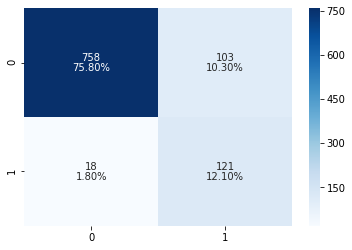

In [70]:
cm(y_test, test_predb)

Confusion Matrix train: 


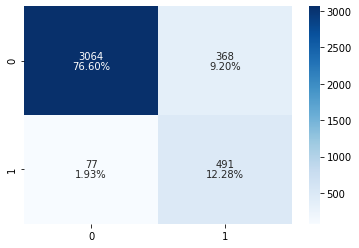

In [71]:
cm(y_train, train_predb, t='train')

In [72]:
indices3 = []
for i, true, pred in zip(y_test.index, y_test.values, test_predb):
    if pred == 0 and true == 1:
        indices3.append(i)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished


(array([4., 3., 1., 1., 1., 3., 1., 0., 2., 2.]),
 array([0.13543305, 0.15894299, 0.18245293, 0.20596287, 0.22947281,
        0.25298275, 0.2764927 , 0.30000264, 0.32351258, 0.34702252,
        0.37053246]),
 <a list of 10 Patch objects>)

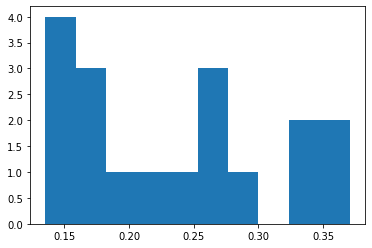

In [73]:
plt.hist(bag.predict_proba(X.loc[indices3])[:, 1])

In [74]:
fn_probs3 = bag.predict_proba(X.loc[indices3])[:, 1]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


In [76]:
print(sorted(fn_probs3))

[0.1354330494070485, 0.13596128061902374, 0.1465854082558554, 0.15260725959357085, 0.16474670621030899, 0.17659165092357473, 0.17679168518706034, 0.19313704059484646, 0.2254912801465901, 0.23504930026852983, 0.2707314845697067, 0.272116585344986, 0.27530830993892513, 0.28368092584278065, 0.3287375672751745, 0.33435500201130336, 0.3492865230042942, 0.37053246020390107]


In [199]:
probs3 = []
for i in bag.predict_proba(X_test):
    if i[1] >=.32:
        probs3.append(1)
    else:
        probs3.append(0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished


Confusion Matrix test: 


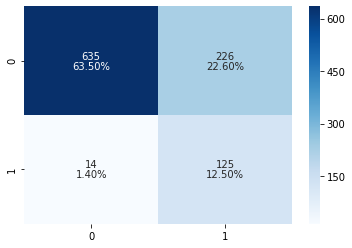

In [200]:
cm(y_test, probs3)

In general there seems to be many more FP with balanced bagging

[Return to contents](#Table-of-Contents)

### Regular bagging with the smoted data

In [314]:
bagreg = BaggingClassifier(base_estimator=rf2, n_jobs=-1, n_estimators=50)

In [315]:
bagreg.fit(X_train_smoted, y_train_smoted)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [316]:
train_predb = bagreg.predict(X_train)
test_predb = bagreg.predict(X_test)

Confusion Matrix test: 


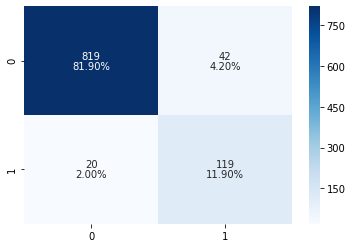

In [317]:
cm(y_test, test_predb)

In [325]:
cost_benefit(y_test, test_predb)

62060

Confusion Matrix train: 


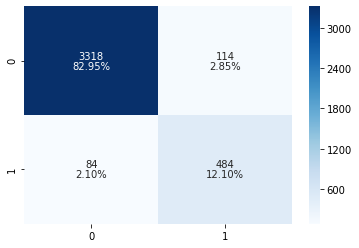

In [318]:
cm(y_train, train_predb, t='train')

In [319]:
print(classification_report(y_test, test_predb))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       861
           1       0.74      0.86      0.79       139

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.86      0.90      0.88      1000
weighted avg       0.94      0.94      0.94      1000



In [89]:
indices3 = []
for i, true, pred in zip(y_test.index, y_test.values, test_predb):
    if pred == 0 and true == 1:
        indices3.append(i)

In [91]:
fn_probs3 = bagreg.predict_proba(X.loc[indices3])[:, 1]

In [93]:
print(sorted(fn_probs3))

[0.05031981080777473, 0.06782617121412092, 0.0722940512139459, 0.07356169762927775, 0.0809499899134925, 0.08255175396434698, 0.09284301776049107, 0.09669710084709796, 0.09913010179089402, 0.10896133224313186, 0.11691999941032576, 0.1263366890508462, 0.15249030088927065, 0.16702677335288388, 0.190008871901414, 0.1912647591562775, 0.22721911542253875, 0.2845891120320088, 0.4707847669517028, 0.49293004625023895]


In [201]:
probs3 = []
for i in bagreg.predict_proba(X_test):
    if i[1] >=.47:
        probs3.append(1)
    else:
        probs3.append(0)

Confusion Matrix test: 


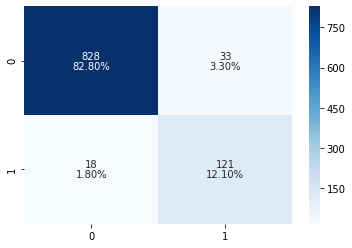

In [202]:
cm(y_test, probs3)

In [324]:
cost_benefit(y_test, probs3)

71320

In [203]:
print(classification_report(y_test, probs3))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       861
           1       0.79      0.87      0.83       139

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.88      0.92      0.90      1000
weighted avg       0.95      0.95      0.95      1000



Much better results

[Return to contents](#Table-of-Contents)

### Cross val with smoted data

In [103]:
skf = StratifiedKFold(n_splits=5)

In [104]:
for train_index, test_index in skf.split(X, y):
    print(len(train_index), len(test_index))

3999 1001
3999 1001
4000 1000
4001 999
4001 999


Get each split from the Kfolds

In [105]:
X_trains2 = {}
X_tests2 = {}
y_trains2 = {}
y_tests2 = {}
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(i)
    print(train_index)
    X_trains2[i] = X.loc[train_index]
    X_tests2[i] = X.loc[test_index]
    y_trains2[i] = y[train_index]
    y_tests2[i] = y[test_index]

0
[ 988  989  990 ... 4997 4998 4999]
1
[   0    1    2 ... 4997 4998 4999]
2
[   0    1    2 ... 4997 4998 4999]
3
[   0    1    2 ... 4997 4998 4999]
4
[   0    1    2 ... 3998 3999 4000]


Get recall scores and cost/benefit from each split then get the mean for each one


0.795774647887324
Confusion Matrix test: 


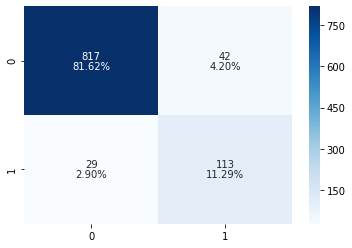

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.73      0.80      0.76       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.85      0.87      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.823943661971831
Confusion Matrix test probs: 


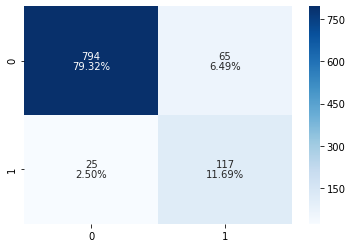

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       859
           1       0.64      0.82      0.72       142

   micro avg       0.91      0.91      0.91      1001
   macro avg       0.81      0.87      0.83      1001
weighted avg       0.92      0.91      0.91      1001


0.8380281690140845
Confusion Matrix test: 


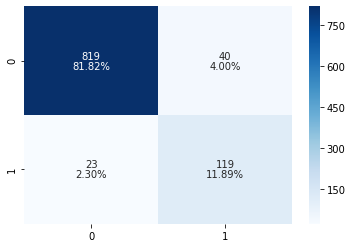

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.75      0.84      0.79       142

   micro avg       0.94      0.94      0.94      1001
   macro avg       0.86      0.90      0.88      1001
weighted avg       0.94      0.94      0.94      1001


0.8450704225352113
Confusion Matrix test probs: 


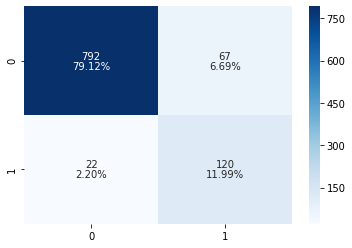

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       859
           1       0.64      0.85      0.73       142

   micro avg       0.91      0.91      0.91      1001
   macro avg       0.81      0.88      0.84      1001
weighted avg       0.93      0.91      0.92      1001


0.7659574468085106
Confusion Matrix test: 


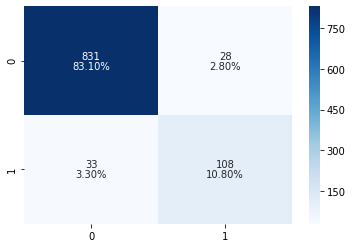

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       859
           1       0.79      0.77      0.78       141

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.94      0.94      0.94      1000


0.8297872340425532
Confusion Matrix test probs: 


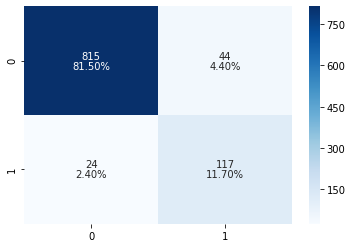

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.73      0.83      0.77       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.85      0.89      0.87      1000
weighted avg       0.94      0.93      0.93      1000


0.7801418439716312
Confusion Matrix test: 


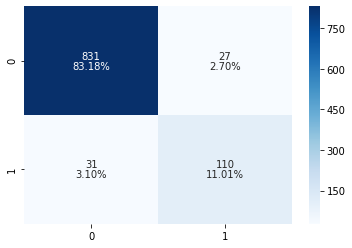

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       858
           1       0.80      0.78      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.88      0.87      0.88       999
weighted avg       0.94      0.94      0.94       999


0.8226950354609929
Confusion Matrix test probs: 


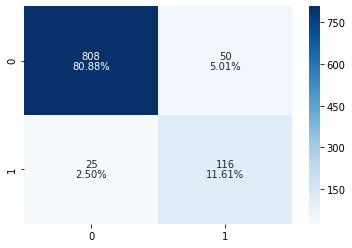

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       858
           1       0.70      0.82      0.76       141

   micro avg       0.92      0.92      0.92       999
   macro avg       0.83      0.88      0.86       999
weighted avg       0.93      0.92      0.93       999


0.8368794326241135
Confusion Matrix test: 


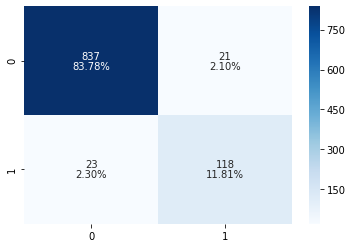

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       858
           1       0.85      0.84      0.84       141

   micro avg       0.96      0.96      0.96       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.96      0.96      0.96       999


0.8723404255319149
Confusion Matrix test probs: 


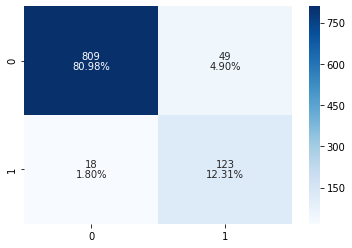

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.72      0.87      0.79       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.85      0.91      0.87       999
weighted avg       0.94      0.93      0.94       999

0.8514869132868444 0.8033563080611328 50952.0 0.8656311954720286 0.8387673559085005 51152.0


In [297]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains2[i], y_trains2[i])
    bagreg.fit(smoted_x, smoted_y)
    trainpred = bagreg.predict(X_trains2[i])
    testpred = bagreg.predict(X_tests2[i])
    train += recall_score(y_trains2[i], trainpred)
    test += recall_score(y_tests2[i], testpred)
    probs = []
    for a in bagreg.predict_proba(X_tests2[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in bagreg.predict_proba(X_trains2[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests2[i], testpred)
    probcb += cost_benefit(y_tests2[i], probs)
    testprobs += recall_score(y_tests2[i], probs)
    trainprobs += recall_score(y_trains2[i], probs2
                              )
    scores2.append((i, recall_score(y_trains2[i], trainpred), recall_score(y_tests2[i], testpred), recall_score(y_trains2[i], probs2), recall_score(y_tests2[i], probs)))
    print(f'\n{recall_score(y_tests2[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests2[i], testpred))
    print(f'\n{recall_score(y_tests2[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests2[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

In [205]:
scores2

[(0,
  0.8495575221238938,
  0.7887323943661971,
  0.8654867256637168,
  0.8309859154929577),
 (1,
  0.8495575221238938,
  0.8309859154929577,
  0.8690265486725663,
  0.8450704225352113),
 (2,
  0.8586572438162544,
  0.7801418439716312,
  0.8692579505300353,
  0.8368794326241135),
 (3,
  0.842756183745583,
  0.7801418439716312,
  0.8586572438162544,
  0.8439716312056738),
 (4,
  0.8533568904593639,
  0.8439716312056738,
  0.8621908127208481,
  0.8652482269503546)]

[Return to contents](#Table-of-Contents)

## Checking feature importance

In [109]:
importance = rf2.feature_importances_

In [110]:
importance

array([0.01377969, 0.00840004, 0.06377159, 0.19488835, 0.06501616,
       0.02765919, 0.14434519, 0.00834097, 0.10735542, 0.04455437,
       0.00778521, 0.0400102 , 0.01957407, 0.00804438, 0.01944651,
       0.0154232 , 0.03807141, 0.0158165 , 0.15771754])

In [111]:
importdf = pd.DataFrame(importance)
importdf['columns'] = X.columns
importdf.sort_values(by=[0], ascending=False)

,0,columns
3,0.194888,international_plan
18,0.157718,number_customer_service_calls
6,0.144345,total_day_minutes
8,0.107355,total_day_charge
4,0.065016,voice_mail_plan
2,0.063772,area_code
9,0.044554,total_eve_minutes
11,0.040010,total_eve_charge
16,0.038071,total_intl_calls
5,0.027659,number_vmail_messages


Testing out the differences with the training and testing data, Keeping the same split to be able to compare

In [112]:
X_trainim = X_train.drop(['total_night_calls', 'total_eve_calls', 'account_length', 'total_day_calls'], axis=1)
X_testim = X_test.drop(['total_night_calls', 'total_eve_calls', 'account_length', 'total_day_calls'], axis=1)

In [113]:
smoted_xim, smoted_yim = sm.fit_sample(X_trainim, y_train)

In [114]:
clfim = RandomForestClassifier()
param_gridim = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [10, 11, 12, 15],
    "min_impurity_decrease": [.0001, .001, .01, .1]
}
gs_treeim = GridSearchCV(clfim, param_gridim, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_treeim.fit(smoted_xim, smoted_yim)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 771 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1581 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.0min finished
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [10, 11, 12, 15], 'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [115]:
rf_gsim = pd.DataFrame(gs_treeim.cv_results_)
rf_gsim.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.042394,0.008741,0.004199,0.000398,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.557984,0.159255,361,0.695446,0.632423,0.404588,0.760743,0.369629,0.572566,0.157158
1,0.306397,0.047001,0.015200,0.001940,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.729312,0.120736,254,0.642987,0.635337,0.795339,0.809541,0.809177,0.738476,0.081287
2,0.491394,0.050968,0.025400,0.002060,gini,1,0.0001,10,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.733683,0.061317,251,0.812750,0.650638,0.644210,0.768390,0.786235,0.732445,0.070869
3,0.060796,0.010284,0.005801,0.002227,gini,1,0.0001,11,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.683858,0.117310,290,0.798179,0.477231,0.637291,0.668609,0.836854,0.683633,0.127728
4,0.239197,0.013183,0.015601,0.004716,gini,1,0.0001,11,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.729312,0.077825,254,0.748998,0.808379,0.657684,0.775310,0.666424,0.731359,0.059698


In [116]:
rf_gsim.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
41,0.452598,0.011862,0.022599,0.000488,gini,1,0.1,11,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,1.000000,0.000000,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
155,1.234993,0.043506,0.047403,0.012883,gini,10,0.0001,15,100,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,0.909382,0.033163,2,0.934062,0.919490,0.915513,0.916970,0.914421,0.920091,0.007189
145,0.623993,0.013886,0.018001,0.000632,gini,10,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,0.909091,0.037990,3,0.935883,0.925319,0.924253,0.919155,0.919155,0.924753,0.006118
337,0.928596,0.077225,0.019400,0.002332,entropy,10,0.0001,10,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.908508,0.033596,4,0.939891,0.926047,0.918791,0.917334,0.916606,0.923734,0.008747
352,0.861795,0.021526,0.017600,0.000490,entropy,10,0.001,11,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.907051,0.034882,5,0.939162,0.920219,0.917698,0.916242,0.913693,0.921403,0.009128


In [117]:
gs_treeim.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_impurity_decrease': 0.1,
 'min_samples_leaf': 11,
 'n_estimators': 100}

In [118]:
gs_treeim.best_score_

1.0

In [119]:
rf4 = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=10, min_impurity_decrease=.0001, min_samples_leaf=10)
rf4.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [120]:
trainpredim = rf4.predict(X_trainim)
testpredim = rf4.predict(X_testim)

Confusion Matrix test: 


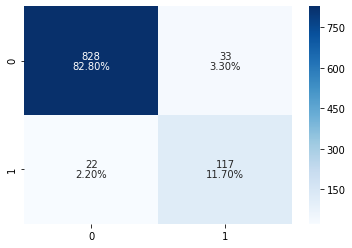

In [121]:
cm(y_test, testpredim)

In [326]:
cost_benefit(y_test, testpredim)

54940

Confusion Matrix train: 


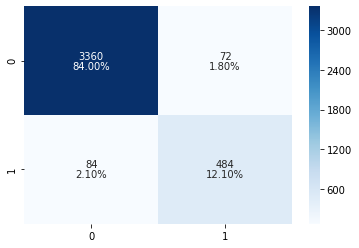

In [122]:
cm(y_train, trainpredim, t='train')

In [123]:
indicesim = []
for i, true, pred in zip(y_test.index, y_test.values, testpredim):
    if pred == 0 and true == 1:
        indicesim.append(i)

In [124]:
fn_probsim = rf4.predict_proba(X_testim.loc[indicesim])[:, 1]
print(sorted(fn_probsim))

[0.044603077317771106, 0.05115671742985085, 0.056951537152658986, 0.07227711456834278, 0.07236372934257598, 0.07440468563319794, 0.08734219015857204, 0.0922206712610333, 0.10060765124098542, 0.10608080938038426, 0.13107391243660008, 0.13843053228645663, 0.15158166135235848, 0.15568017594112568, 0.15935432332016952, 0.1903809790142515, 0.23751836863539263, 0.30963888339399337, 0.35464990379709144, 0.4358008142958005, 0.45672495609816477, 0.47352892181978]


In [125]:
probsim = []
for a in rf4.predict_proba(X_testim):
    if a[1] >=.45:
        probsim.append(1)
    else:
        probsim.append(0)

Confusion Matrix test: 


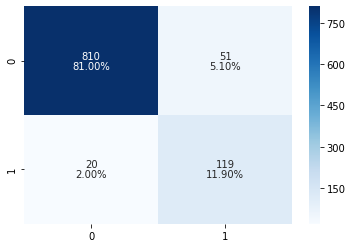

In [126]:
cm(y_test, probsim)

In [327]:
cost_benefit(y_test, probsim)

47700

In [127]:
probsimtr = []
for a in rf4.predict_proba(X_trainim):
    if a[1] >=.45:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


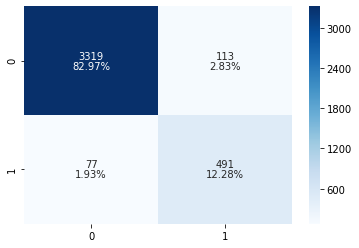

In [128]:
cm(y_train, probsimtr, t = 'train')

In [129]:
bagregim = BaggingClassifier(base_estimator=rf4, n_jobs=-1, n_estimators=50)

In [130]:
bagregim.fit(smoted_xim, smoted_yim)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [131]:
train_predbim = bagregim.predict(X_trainim)
test_predbim = bagregim.predict(X_testim)

Confusion Matrix test: 


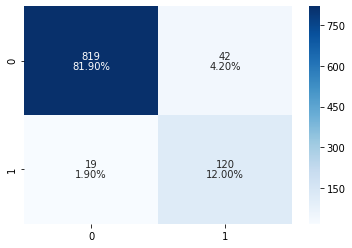

In [132]:
cm(y_test, test_predbim)

In [323]:
cost_benefit(y_test, test_predbim)

53060

Confusion Matrix train: 


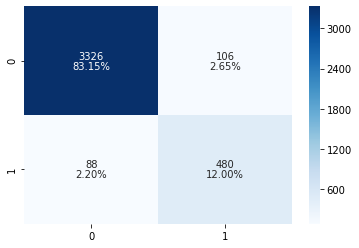

In [133]:
cm(y_train, train_predbim, t='train')

In [134]:
indicesbim = []
for i, true, pred in zip(y_test.index, y_test.values, test_predbim):
    if pred == 0 and true == 1:
        indicesbim.append(i)

In [135]:
fn_probsbim = bagregim.predict_proba(X_testim.loc[indicesbim])[:, 1]
print(sorted(fn_probsbim))

[0.04487474392125102, 0.08500214061887401, 0.09095718151876037, 0.091082326795746, 0.09250249156690281, 0.09281044876997128, 0.09449823626070149, 0.09705271977802593, 0.09783706855287547, 0.10843478273806859, 0.13891261654415105, 0.14060028211844425, 0.14871840461536584, 0.17074007628453308, 0.18551675622010794, 0.19380375724353396, 0.23967059225934462, 0.28112885572654367, 0.4675559032635362]


In [136]:
probsim = []
for a in bagregim.predict_proba(X_testim):
    if a[1] >=.44:
        probsim.append(1)
    else:
        probsim.append(0)

Confusion Matrix test: 


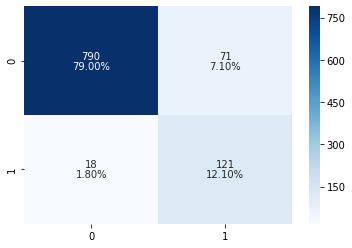

In [137]:
cm(y_test, probsim)

In [322]:
cost_benefit(y_test, probsim)

47700

In [138]:
probsimtr = []
for a in bagregim.predict_proba(X_trainim):
    if a[1] >=.41:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


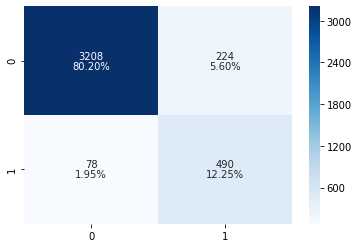

In [139]:
cm(y_train, probsimtr, t = 'train')

Our cost benefit did go down, however it is about where our average was from cross validation.  
Let's see what we can get if we work on this more to improve our interpretability

In [140]:
rf4.feature_importances_

array([0.01557499, 0.03593217, 0.18820763, 0.06078703, 0.03027024,
       0.15997228, 0.12255065, 0.04160524, 0.04047217, 0.01601422,
       0.02159409, 0.01655228, 0.04537414, 0.01554619, 0.18954668])

In [141]:
importdf2 = pd.DataFrame(rf4.feature_importances_)
importdf2['columns'] = X_trainim.columns
importdf2.sort_values(by=[0], ascending=False)

,0,columns
14,0.189547,number_customer_service_calls
2,0.188208,international_plan
5,0.159972,total_day_minutes
6,0.122551,total_day_charge
3,0.060787,voice_mail_plan
12,0.045374,total_intl_calls
7,0.041605,total_eve_minutes
8,0.040472,total_eve_charge
1,0.035932,area_code
4,0.030270,number_vmail_messages


Drop charge and call columns, then combine the charge columns into one

In [142]:
X_trainim = X_train.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls'], axis=1)
X_testim = X_test.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls'], axis=1)

Also drop low value columns, this was after iterating through the above and seeing that they are still very low compared to the other columns

In [143]:
X_trainim = X_trainim.drop(['state', 'account_length', 'area_code'], axis = 1)
X_testim = X_testim.drop(['state', 'account_length', 'area_code'], axis = 1)

Combining the charge columns

In [144]:
X_trainim['combined_charges'] = X_train['total_day_charge'] + X_train['total_eve_charge'] + X_train['total_intl_charge'] + X_train['total_night_charge']
X_testim['combined_charges'] = X_test['total_day_charge'] + X_test['total_eve_charge'] + X_test['total_intl_charge'] + X_test['total_night_charge']

Combining the minutes columns

In [145]:
X_trainim['total_min'] = X_train['total_day_minutes'] + X_train['total_eve_minutes'] + X_train['total_intl_minutes'] + X_train['total_night_minutes']
X_testim['total_min'] = X_test['total_day_minutes'] + X_test['total_eve_minutes'] + X_test['total_intl_minutes'] + X_test['total_night_minutes']

Droppping the indivdual minutes columns

In [146]:
X_trainim = X_trainim.drop(['total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes'], axis = 1)
X_testim = X_testim.drop(['total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes'], axis = 1)

Dropped due to the extremely high correlation between minutes and charges, also dropped number_vmail_messages due to high correlation with voice_mail_plan

In [147]:
X_trainim = X_trainim.drop(['total_min', 'number_vmail_messages'], axis = 1)
X_testim = X_testim.drop(['total_min', 'number_vmail_messages'], axis = 1)

In [148]:
smoted_xim, smoted_yim = sm.fit_sample(X_trainim, y_train)

In [149]:
clfim = RandomForestClassifier()
param_gridim = {
    "n_estimators": [10,50,100],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_leaf": [8, 10, 12, 14],
    "min_impurity_decrease": [.0001, .001, .01, .1]
}
gs_treeim = GridSearchCV(clfim, param_gridim, cv=5, scoring='recall',  n_jobs=-1, verbose=2)
gs_treeim.fit(smoted_xim, smoted_yim)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_leaf': [8, 10, 12, 14], 'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [150]:
rf_gsim = pd.DataFrame(gs_treeim.cv_results_)
rf_gsim.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.029991,0.003292,0.003601,0.000490,gini,1,0.0001,8,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.779720,0.094237,254,0.918761,0.685246,0.687546,0.912600,0.691187,0.779068,0.111577
1,0.184200,0.012481,0.012400,0.000801,gini,1,0.0001,8,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.690559,0.147669,298,0.473224,0.701275,0.688638,0.688274,0.909687,0.692220,0.138102
2,0.394400,0.052244,0.029400,0.003827,gini,1,0.0001,8,100,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.782634,0.119393,248,0.693260,0.701275,0.905681,0.688274,0.909323,0.779563,0.104551
3,0.044800,0.010304,0.004600,0.000490,gini,1,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.587704,0.117489,321,0.692532,0.701275,0.473416,0.418791,0.687181,0.594639,0.122585
4,0.204400,0.024500,0.014200,0.002135,gini,1,0.0001,10,50,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...",...,0.648019,0.089280,313,0.693260,0.701275,0.689002,0.688274,0.469410,0.648244,0.089537


In [151]:
rf_gsim.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
349,0.392999,0.010564,0.015801,0.000749,entropy,10,0.001,8,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.924242,0.041874,1,0.943898,0.928233,0.928259,0.931901,0.928259,0.932110,0.006061
338,0.831799,0.009020,0.034200,0.001468,entropy,10,0.0001,8,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.923660,0.043769,2,0.942441,0.928962,0.925346,0.930080,0.927531,0.930872,0.005997
350,0.779999,0.033828,0.030200,0.000749,entropy,10,0.001,8,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.923077,0.039832,3,0.939526,0.926412,0.924982,0.931173,0.926803,0.929779,0.005295
147,0.064800,0.001601,0.004801,0.000400,gini,10,0.0001,10,10,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",...,0.922786,0.040975,4,0.940619,0.926776,0.918791,0.927167,0.920612,0.926793,0.007662
352,0.394000,0.011628,0.017600,0.001356,entropy,10,0.001,10,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",...,0.922203,0.043818,5,0.941348,0.930055,0.927167,0.927895,0.923889,0.930071,0.005976


In [152]:
gs_treeim.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 8,
 'n_estimators': 50}

In [207]:
rf5 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=10, min_impurity_decrease=.001, min_samples_leaf=8)
rf5.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [208]:
trainpredim = rf5.predict(X_trainim)
testpredim = rf5.predict(X_testim)

Confusion Matrix test: 


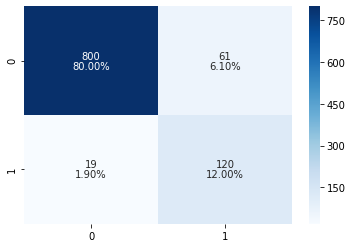

In [209]:
cm(y_test, testpredim)

In [328]:
cost_benefit(y_test, testpredim)

54940

Confusion Matrix train: 


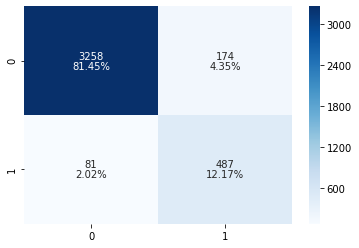

In [210]:
cm(y_train, trainpredim, t='train')

In [211]:
indicesim = []
for i, true, pred in zip(y_test.index, y_test.values, testpredim):
    if pred == 0 and true == 1:
        indicesim.append(i)

In [212]:
fn_probsim = rf5.predict_proba(X_testim.loc[indicesim])[:, 1]
print(sorted(fn_probsim))

[0.03237117386436316, 0.03237117386436316, 0.03552087104388792, 0.03628277580579268, 0.04446253659741009, 0.04758243756824312, 0.051293443967930126, 0.05268416673823774, 0.07175687279249517, 0.07698795462846642, 0.08206411422834506, 0.08227478274729073, 0.09327969360974592, 0.10715365461079351, 0.1108905851827785, 0.1530442454670099, 0.17554289095709677, 0.4894575630291626, 0.4985760474908058]


In [213]:
probsim = []
for a in rf5.predict_proba(X_testim):
    if a[1] >=.4:
        probsim.append(1)
    else:
        probsim.append(0)

Confusion Matrix test: 


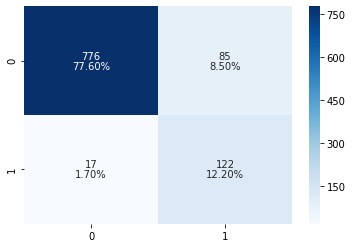

In [214]:
cm(y_test, probsim)

In [329]:
cost_benefit(y_test, probsim)

47700

In [215]:
probsimtr = []
for a in rf5.predict_proba(X_trainim):
    if a[1] >=.4:
        probsimtr.append(1)
    else:
        probsimtr.append(0)

Confusion Matrix train: 


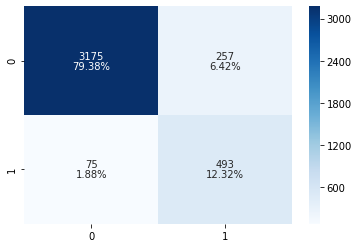

In [216]:
cm(y_train, probsimtr, t = 'train')

In [217]:
print(classification_report(y_test, probsim))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       861
           1       0.59      0.88      0.71       139

   micro avg       0.90      0.90      0.90      1000
   macro avg       0.78      0.89      0.82      1000
weighted avg       0.92      0.90      0.91      1000



In [218]:
print(classification_report(y_test, testpredim))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       861
           1       0.66      0.86      0.75       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.90      0.85      1000
weighted avg       0.93      0.92      0.92      1000



In [219]:
importdf2 = pd.DataFrame(rf5.feature_importances_)
importdf2['columns'] = X_trainim.columns
importdf2.sort_values(by=[0], ascending=False)

,0,columns
3,0.462186,combined_charges
2,0.230713,number_customer_service_calls
0,0.220396,international_plan
1,0.086705,voice_mail_plan


In [220]:
bagregim = BaggingClassifier(base_estimator=rf5, n_jobs=-1, n_estimators=50)

In [221]:
bagregim.fit(smoted_xim, smoted_yim)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [222]:
train_predbim = bagregim.predict(X_trainim)
test_predbim = bagregim.predict(X_testim)

Confusion Matrix test: 


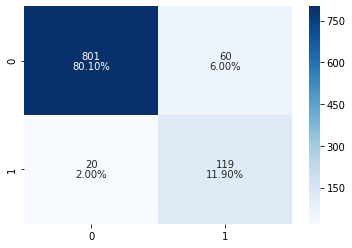

In [223]:
cm(y_test, test_predbim)

In [330]:
cost_benefit(y_test, test_predbim)

53060

Confusion Matrix train: 


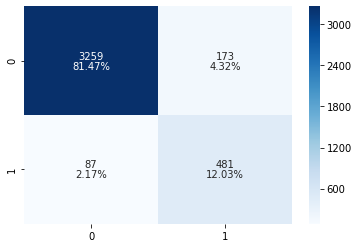

In [224]:
cm(y_train, train_predbim, t='train')

In [225]:
print(classification_report(y_test, test_predbim))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       861
           1       0.66      0.86      0.75       139

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.89      0.85      1000
weighted avg       0.93      0.92      0.92      1000



In [226]:
test = pd.concat([X_trainim, y_train], axis=1) 

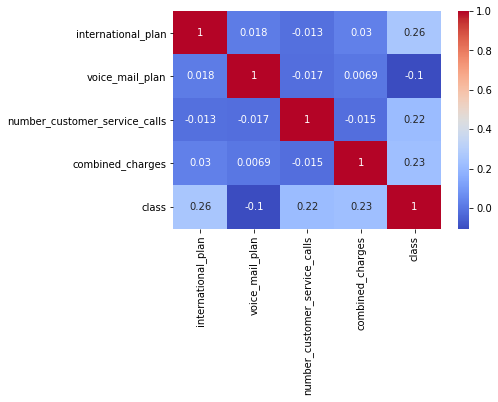

In [227]:
sns.heatmap(test.corr(), cmap='coolwarm', annot=True)

In general it seems similar to our cost benefit from the above cross validation, let's see what doing cross validation with this information will provide us

In [270]:
Xim = X.copy()

In [271]:
Xim['combined_charges'] = Xim['total_day_charge'] + Xim['total_eve_charge'] + Xim['total_intl_charge'] + Xim['total_night_charge']

In [272]:
Xim = Xim.drop(['total_day_charge', 'total_eve_charge', 'total_intl_charge', 'total_night_charge', 'total_night_calls', 'total_intl_calls', 'total_eve_calls', 'total_day_calls', 'state', 'account_length', 'area_code', 'total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'total_night_minutes', 'number_vmail_messages'], axis=1)

In [278]:
Xim.combined_charges.describe()

count    5000.000000
mean       59.492918
std        10.352006
min        22.930000
25%        52.480000
50%        59.510000
75%        66.392500
max        96.150000
Name: combined_charges, dtype: float64

In [274]:
X_trains3 = {}
X_tests3 = {}
y_trains3 = {}
y_tests3 = {}
for i, (train_index, test_index) in enumerate(skf.split(Xim, y)):
    print(i)
    print(train_index)
    X_trains3[i] = Xim.loc[train_index]
    X_tests3[i] = Xim.loc[test_index]
    y_trains3[i] = y[train_index]
    y_tests3[i] = y[test_index]

0
[ 988  989  990 ... 4997 4998 4999]
1
[   0    1    2 ... 4997 4998 4999]
2
[   0    1    2 ... 4997 4998 4999]
3
[   0    1    2 ... 4997 4998 4999]
4
[   0    1    2 ... 3998 3999 4000]



0.8309859154929577
Confusion Matrix test: 


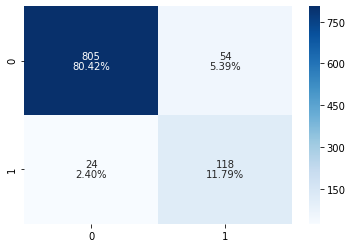

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.83      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.852112676056338
Confusion Matrix test probs: 


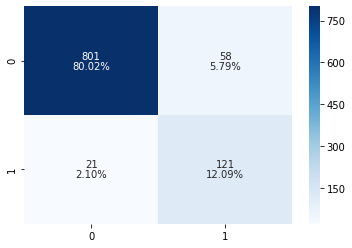

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.68      0.85      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.89      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8169014084507042
Confusion Matrix test: 


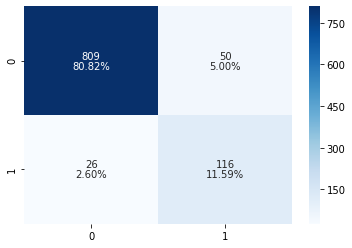

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.8169014084507042
Confusion Matrix test probs: 


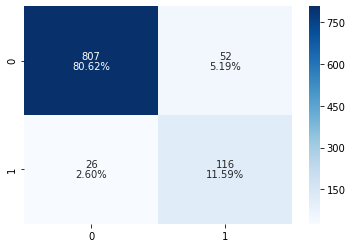

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8156028368794326
Confusion Matrix test: 


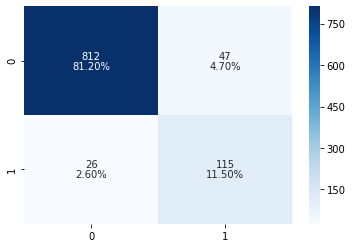

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.71      0.82      0.76       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.88      0.86      1000
weighted avg       0.93      0.93      0.93      1000


0.8368794326241135
Confusion Matrix test probs: 


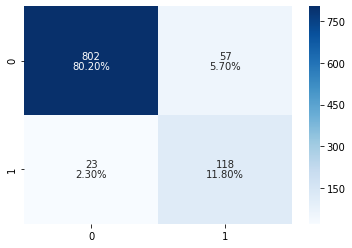

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.67      0.84      0.75       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.89      0.85      1000
weighted avg       0.93      0.92      0.92      1000


0.8865248226950354
Confusion Matrix test: 


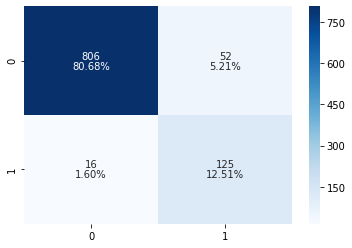

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.71      0.89      0.79       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.94       999


0.8865248226950354
Confusion Matrix test probs: 


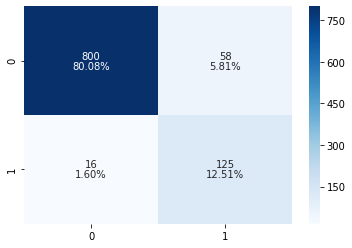

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       858
           1       0.68      0.89      0.77       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.83      0.91      0.86       999
weighted avg       0.94      0.93      0.93       999


0.8723404255319149
Confusion Matrix test: 


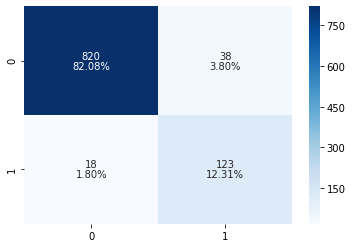

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       858
           1       0.76      0.87      0.81       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.87      0.91      0.89       999
weighted avg       0.95      0.94      0.95       999


0.8794326241134752
Confusion Matrix test probs: 


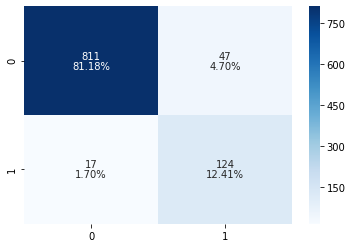

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.73      0.88      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.85      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8571424997654711 0.844471081810009 56456.0 0.8645679977485224 0.8543701927879332 56688.0


In [299]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    bagregim.fit(smoted_x, smoted_y)
    trainpred = bagregim.predict(X_trains3[i])
    testpred = bagregim.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in bagregim.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in bagregim.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)


0.852112676056338
Confusion Matrix test: 


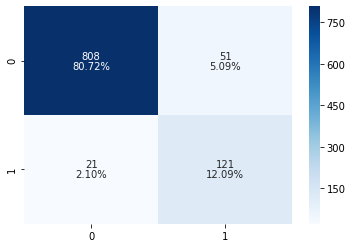

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.85      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.90      0.86      1001
weighted avg       0.94      0.93      0.93      1001


0.8661971830985915
Confusion Matrix test probs: 


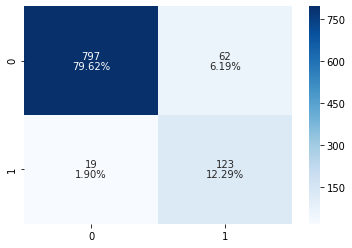

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       859
           1       0.66      0.87      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.90      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8169014084507042
Confusion Matrix test: 


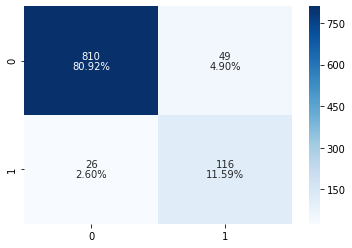

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.82      0.76       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.88      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.8169014084507042
Confusion Matrix test probs: 


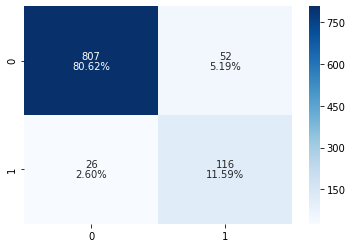

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.7943262411347518
Confusion Matrix test: 


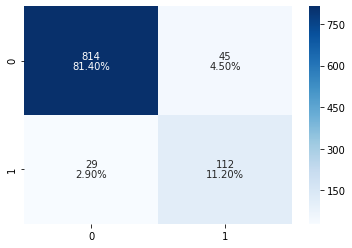

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.71      0.79      0.75       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.87      0.85      1000
weighted avg       0.93      0.93      0.93      1000


0.8297872340425532
Confusion Matrix test probs: 


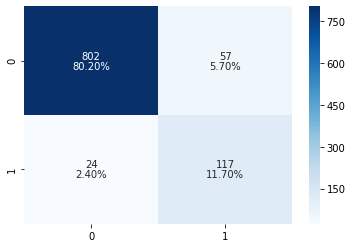

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.67      0.83      0.74       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.88      0.85      1000
weighted avg       0.93      0.92      0.92      1000


0.8865248226950354
Confusion Matrix test: 


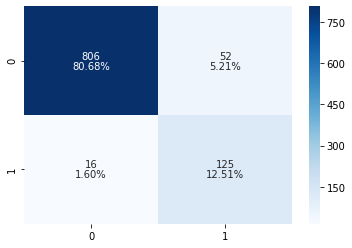

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.71      0.89      0.79       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.94       999


0.8865248226950354
Confusion Matrix test probs: 


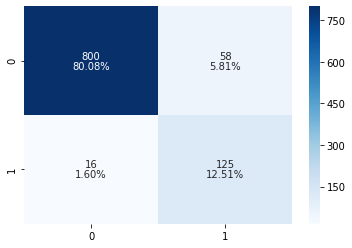

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       858
           1       0.68      0.89      0.77       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.83      0.91      0.86       999
weighted avg       0.94      0.93      0.93       999


0.8581560283687943
Confusion Matrix test: 


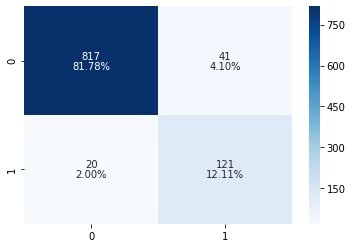

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.75      0.86      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999


0.8794326241134752
Confusion Matrix test probs: 


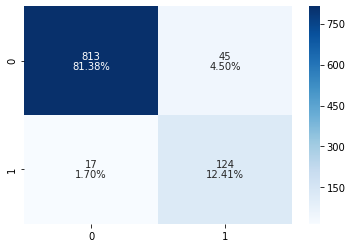

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.73      0.88      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8589099096281935 0.8416042353411248 55804.0 0.8649232308702587 0.8557686544800719 56964.0


In [301]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    rf5.fit(smoted_x, smoted_y)
    trainpred = rf5.predict(X_trains3[i])
    testpred = rf5.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in rf5.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in rf5.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

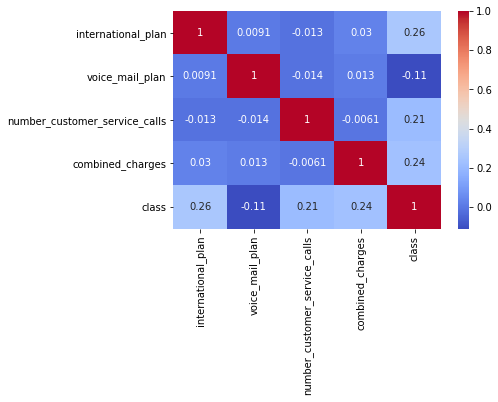

In [303]:
imdf = pd.concat([Xim, y], axis=1)
sns.heatmap(imdf.corr(), cmap='coolwarm', annot=True)

The cost/benefit of the cross validation is better without bagging and is better then the cost/benefit from the cross validation that was done with all the features

[Return to contents](#Table-of-Contents)

## XbBoost

In [174]:
clf = xgb.XGBClassifier()

In [175]:
param_grid = {
    "learning_rate": [0.1, .01, .2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [8, 10, 12],
    'subsample': [.6, 0.7, .8],
    'n_estimators': [5, 30, 100, 250],
}

In [176]:
grid_xb = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_xb.fit(X_train_smoted, y_train_smoted)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [8, 10, 12], 'subsample': [0.6, 0.7, 0.8], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [177]:
xb_gs = pd.DataFrame(grid_xb.cv_results_)
xb_gs.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.113393,0.016342,0.003600,1.354324e-03,0.1,4,8,5,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.810897,0.039607,304,0.842623,0.807650,0.808084,0.824472,0.809541,0.818474,0.013594
1,0.093598,0.036857,0.002802,4.007106e-04,0.1,4,8,5,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.812937,0.047043,298,0.834973,0.805464,0.813183,0.816460,0.840859,0.822188,0.013458
2,0.110597,0.030883,0.004800,3.187640e-03,0.1,4,8,5,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.811189,0.044544,301,0.833515,0.807286,0.814275,0.813911,0.815368,0.816871,0.008794
3,0.404200,0.083520,0.004400,4.904474e-04,0.1,4,8,30,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.891900,0.071062,210,0.944627,0.904918,0.904953,0.903496,0.910051,0.913609,0.015668
4,0.405396,0.062368,0.004001,1.784161e-07,0.1,4,8,30,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.890152,0.073124,212,0.941348,0.901275,0.910051,0.906773,0.912236,0.914337,0.014001


In [178]:
xb_gs.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
293,0.652395,0.016812,0.005801,0.000400,0.2,8,8,30,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.944930,0.088997,1,0.992714,0.966849,0.966497,0.966497,0.963948,0.971301,0.010757
292,0.632998,0.022916,0.005200,0.000401,0.2,8,8,30,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.938811,0.102738,2,0.994171,0.965027,0.966861,0.965404,0.965040,0.971301,0.011455
79,1.984197,0.068402,0.014401,0.000490,0.1,8,8,100,0.7,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.937063,0.114165,3,0.995628,0.971949,0.971231,0.971595,0.971959,0.976473,0.009582
80,2.096398,0.071343,0.014601,0.001020,0.1,8,8,100,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.936772,0.116202,4,0.996357,0.973042,0.974508,0.971959,0.973780,0.977929,0.009252
291,0.599997,0.014157,0.005400,0.000489,0.2,8,8,30,0.6,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.935897,0.100567,5,0.993078,0.962477,0.963948,0.963219,0.962127,0.968970,0.012071


In [179]:
xb_gs['test_train_diff'] = xb_gs['mean_train_score'] - xb_gs['mean_test_score']

In [180]:
xb_gs['wighted_test'] = xb_gs['mean_test_score'] - xb_gs['test_train_diff']

In [181]:
xb_gs.sort_values(by=['wighted_test'], ascending=False).drop(['split0_train_score', 'split1_train_score'], axis=1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,test_train_diff,wighted_test
293,0.652395,0.016812,0.005801,0.000400,0.2,8,8,30,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.944930,0.088997,1,0.966497,0.966497,0.963948,0.971301,0.010757,0.026371,0.918559
41,0.558397,0.018161,0.004600,0.000489,0.1,6,8,30,0.8,"{'learning_rate': 0.1, 'max_depth': 6, 'min_ch...",...,0.926865,0.052320,36,0.937728,0.942098,0.936635,0.944713,0.015803,0.017848,0.909017
76,0.681596,0.047719,0.005000,0.000002,0.1,8,8,30,0.7,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.931235,0.058089,13,0.942826,0.946103,0.951930,0.953454,0.015633,0.022219,0.909017
77,0.679197,0.012640,0.005200,0.000400,0.1,8,8,30,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.931818,0.052845,11,0.949745,0.949381,0.950838,0.954984,0.014080,0.023165,0.908653
292,0.632998,0.022916,0.005200,0.000401,0.2,8,8,30,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.938811,0.102738,2,0.966861,0.965404,0.965040,0.971301,0.011455,0.032490,0.906322


In [182]:
grid_xb.best_params_

{'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 8,
 'n_estimators': 30,
 'subsample': 0.8}

In [229]:
xb2 = xgb.XGBClassifier(learning_rate=.1, max_depth=6, min_child_weight=8, n_estimators=30, subsample=.8)

In [230]:
xsmote = pd.DataFrame(X_train_smoted, columns=X.columns)

In [231]:
xb2.fit(xsmote, y_train_smoted)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=30, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.8, verbosity=1)

In [232]:
train_pred3 = xb2.predict(X_train)
train_pred_smoted3 = xb2.predict(xsmote)
test_pred3 = xb2.predict(X_test)

Confusion Matrix test: 


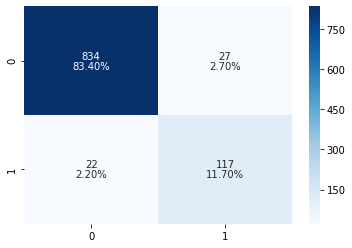

In [233]:
cm(y_test, test_pred3)

Confusion Matrix train: 


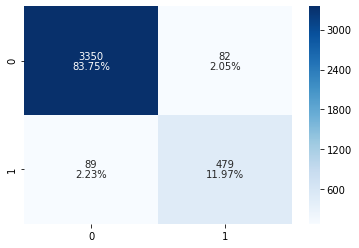

In [234]:
cm(y_train, train_pred3, t='train')

Confusion Matrix train_smoted: 


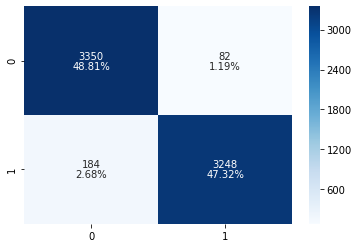

In [235]:
cm(y_train_smoted, train_pred_smoted3, t='train_smoted')

In [236]:
print(classification_report(y_test, test_pred3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       861
           1       0.81      0.84      0.83       139

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.89      0.91      0.90      1000
weighted avg       0.95      0.95      0.95      1000



In [237]:
print(classification_report(y_train, train_pred3))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3432
           1       0.85      0.84      0.85       568

   micro avg       0.96      0.96      0.96      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.96      0.96      0.96      4000



In [238]:
xb2.feature_importances_

array([0.00944524, 0.00823937, 0.04716232, 0.23317155, 0.09145758,
       0.00905695, 0.1019813 , 0.00347815, 0.12493359, 0.04297966,
       0.00791517, 0.02974966, 0.01464474, 0.00828036, 0.02701434,
       0.03253403, 0.03771191, 0.05299428, 0.11724992], dtype=float32)

In [239]:
importxb = pd.DataFrame(xb2.feature_importances_)
importxb['columns'] = X_train.columns
importxb.sort_values(by=[0], ascending=False)

,0,columns
3,0.233172,international_plan
8,0.124934,total_day_charge
18,0.117250,number_customer_service_calls
6,0.101981,total_day_minutes
4,0.091458,voice_mail_plan
17,0.052994,total_intl_charge
2,0.047162,area_code
9,0.042980,total_eve_minutes
16,0.037712,total_intl_calls
15,0.032534,total_intl_minutes


In [248]:
grid_xb2 = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_xb2.fit(smoted_xim, smoted_yim)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [8, 10, 12], 'subsample': [0.6, 0.7, 0.8], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [249]:
xb_gs2 = pd.DataFrame(grid_xb2.cv_results_)
xb_gs2.head()

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\l

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021000,0.002097,0.002001,0.000895,0.1,4,8,5,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.896853,0.022850,205,0.912933,0.889617,0.899126,0.894028,0.902039,0.899549,0.007932
1,0.043399,0.024573,0.003000,0.001095,0.1,4,8,5,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.904138,0.021395,147,0.915847,0.904554,0.900218,0.904953,0.903496,0.905814,0.005285
2,0.029400,0.003072,0.001801,0.000399,0.1,4,8,5,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.905303,0.021264,137,0.915847,0.905282,0.900218,0.906409,0.903496,0.906251,0.005235
3,0.127798,0.024010,0.002600,0.000490,0.1,4,8,30,0.6,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.901807,0.027950,157,0.927505,0.904918,0.900583,0.905317,0.903860,0.908436,0.009678
4,0.152400,0.008238,0.002800,0.000399,0.1,4,8,30,0.7,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.900058,0.031898,166,0.923497,0.905282,0.900583,0.906409,0.903860,0.907926,0.008028


In [250]:
xb_gs2.sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
323,2.869120,0.209824,0.036001,0.003287,0.2,8,12,250,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.928904,0.064436,1,0.960656,0.944991,0.945011,0.948653,0.946832,0.949228,0.005872
107,1.552000,0.036916,0.026999,0.001096,0.1,8,12,250,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.928904,0.064436,1,0.956284,0.938798,0.941369,0.941005,0.941369,0.943765,0.006332
94,1.386403,0.026311,0.026597,0.000799,0.1,8,10,250,0.7,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.928322,0.065390,3,0.957741,0.940619,0.940641,0.943918,0.942462,0.945076,0.006452
298,1.630199,0.068741,0.030001,0.003163,0.2,8,8,250,0.7,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.928322,0.069629,3,0.969035,0.949362,0.950838,0.954843,0.951566,0.955129,0.007181
311,4.111126,1.187967,0.036602,0.004224,0.2,8,10,250,0.8,"{'learning_rate': 0.2, 'max_depth': 8, 'min_ch...",...,0.928322,0.068283,3,0.964663,0.950091,0.949381,0.952658,0.950838,0.953526,0.005674


In [251]:
xb_gs2['test_train_diff'] = xb_gs2['mean_train_score'] - xb_gs2['mean_test_score']

In [252]:
xb_gs2['weighted_test'] = xb_gs2['mean_test_score'] - xb_gs2['test_train_diff']

In [253]:
xb_gs2.sort_values(by=['weighted_test'], ascending=False).drop(['split0_train_score', 'split1_train_score'], axis=1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,...,mean_test_score,std_test_score,rank_test_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,test_train_diff,weighted_test
69,1.231003,0.075032,0.022197,0.000744,0.1,6,12,250,0.6,"{'learning_rate': 0.1, 'max_depth': 6, 'min_ch...",...,0.927156,0.059691,11,0.935543,0.939184,0.934086,0.940196,0.007858,0.013040,0.914116
23,0.848800,0.027779,0.017400,0.000800,0.1,4,10,250,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",...,0.927156,0.063924,11,0.933358,0.937728,0.934086,0.940196,0.008815,0.013040,0.914116
107,1.552000,0.036916,0.026999,0.001096,0.1,8,12,250,0.8,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.928904,0.064436,1,0.941369,0.941005,0.941369,0.943765,0.006332,0.014861,0.914044
105,2.076004,0.181491,0.024995,0.000636,0.1,8,12,250,0.6,"{'learning_rate': 0.1, 'max_depth': 8, 'min_ch...",...,0.927448,0.059716,6,0.938092,0.939913,0.934086,0.941070,0.007485,0.013623,0.913825
57,1.152600,0.026650,0.022401,0.000490,0.1,6,10,250,0.6,"{'learning_rate': 0.1, 'max_depth': 6, 'min_ch...",...,0.927156,0.063471,11,0.938820,0.938456,0.934814,0.940924,0.007270,0.013768,0.913388


In [254]:
grid_xb2.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 12,
 'n_estimators': 250,
 'subsample': 0.8}

In [256]:
xb2 = xgb.XGBClassifier(learning_rate=.1, max_depth=6, min_child_weight=12, n_estimators=250, subsample=.6)

In [257]:
xsmote = pd.DataFrame(smoted_xim, columns=X_trainim.columns)

In [258]:
xb2.fit(xsmote, smoted_yim)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=12, missing=None,
       n_estimators=250, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.6, verbosity=1)

In [259]:
train_pred3 = xb2.predict(X_trainim)
train_pred_smoted3 = xb2.predict(xsmote)
test_pred3 = xb2.predict(X_testim)

Confusion Matrix test: 


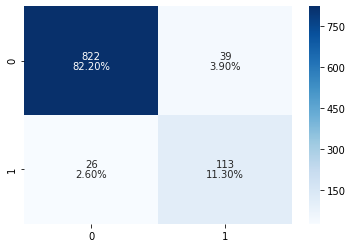

In [260]:
cm(y_test, test_pred3)

Confusion Matrix train: 


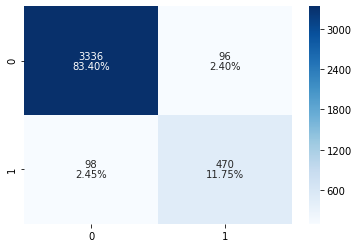

In [261]:
cm(y_train, train_pred3, t='train')

Confusion Matrix train_smoted: 


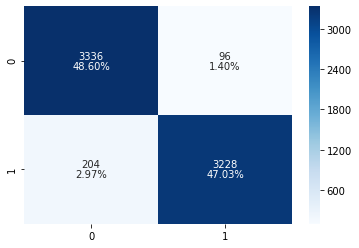

In [262]:
cm(y_train_smoted, train_pred_smoted3, t='train_smoted')

In [263]:
print(classification_report(y_test, test_pred3))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       861
           1       0.74      0.81      0.78       139

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.86      0.88      0.87      1000
weighted avg       0.94      0.94      0.94      1000



In [264]:
print(classification_report(y_train, train_pred3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3432
           1       0.83      0.83      0.83       568

   micro avg       0.95      0.95      0.95      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.95      0.95      0.95      4000




0.7887323943661971
Confusion Matrix test: 


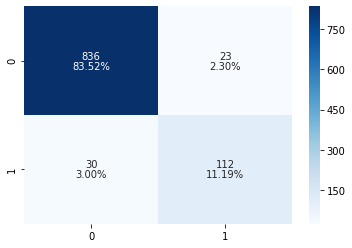

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       859
           1       0.83      0.79      0.81       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.90      0.88      0.89      1001
weighted avg       0.95      0.95      0.95      1001


0.8098591549295775
Confusion Matrix test probs: 


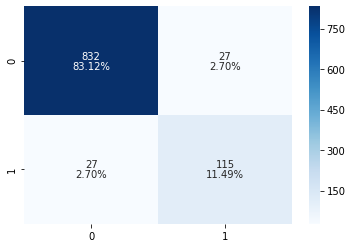

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       859
           1       0.81      0.81      0.81       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.89      0.89      0.89      1001
weighted avg       0.95      0.95      0.95      1001


0.795774647887324
Confusion Matrix test: 


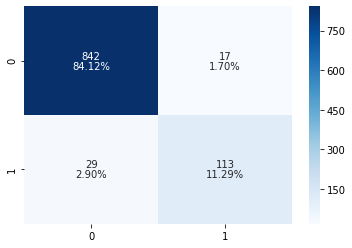

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       859
           1       0.87      0.80      0.83       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.92      0.89      0.90      1001
weighted avg       0.95      0.95      0.95      1001


0.823943661971831
Confusion Matrix test probs: 


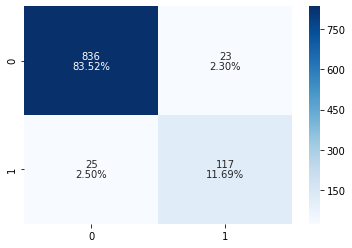

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       859
           1       0.84      0.82      0.83       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.90      0.90      0.90      1001
weighted avg       0.95      0.95      0.95      1001


0.7446808510638298
Confusion Matrix test: 


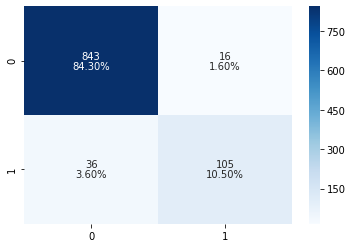

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       859
           1       0.87      0.74      0.80       141

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.91      0.86      0.89      1000
weighted avg       0.95      0.95      0.95      1000


0.7659574468085106
Confusion Matrix test probs: 


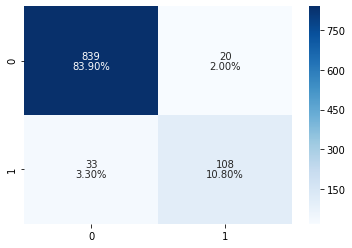

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       859
           1       0.84      0.77      0.80       141

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.90      0.87      0.89      1000
weighted avg       0.95      0.95      0.95      1000


0.7588652482269503
Confusion Matrix test: 


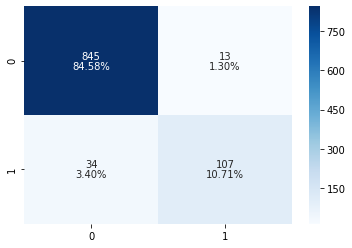

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       858
           1       0.89      0.76      0.82       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.93      0.87      0.90       999
weighted avg       0.95      0.95      0.95       999


0.7872340425531915
Confusion Matrix test probs: 


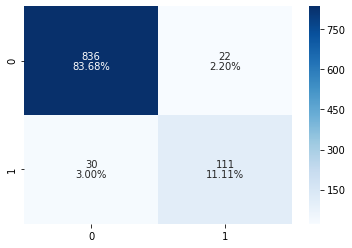

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.83      0.79      0.81       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.90      0.88      0.89       999
weighted avg       0.95      0.95      0.95       999


0.8156028368794326
Confusion Matrix test: 


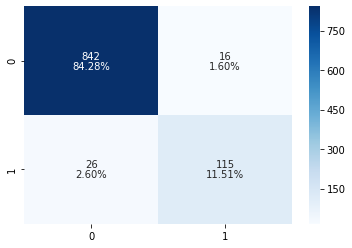

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       858
           1       0.88      0.82      0.85       141

   micro avg       0.96      0.96      0.96       999
   macro avg       0.92      0.90      0.91       999
weighted avg       0.96      0.96      0.96       999


0.8439716312056738
Confusion Matrix test probs: 


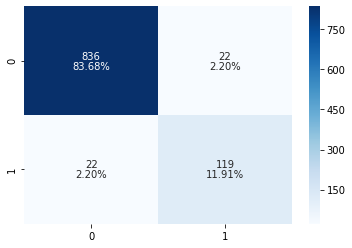

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.84      0.84      0.84       141

   micro avg       0.96      0.96      0.96       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.96      0.96      0.96       999

0.8688132837174395 0.7807311956847467 50636.0 0.8836649050939679 0.8061931874937569 56304.0


In [294]:
scores3 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains2[i], y_trains2[i])
    xsmote = pd.DataFrame(smoted_x, columns=X.columns)
    xb2.fit(xsmote, smoted_y)
    trainpred = xb2.predict(X_trains2[i])
    testpred = xb2.predict(X_tests2[i])
    train += recall_score(y_trains2[i], trainpred)
    test += recall_score(y_tests2[i], testpred)
    probs = []
    for a in xb2.predict_proba(X_tests2[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in xb2.predict_proba(X_trains2[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests2[i], testpred)
    probcb += cost_benefit(y_tests2[i], probs)
    testprobs += recall_score(y_tests2[i], probs)
    trainprobs += recall_score(y_trains2[i], probs2)
    scores2.append((i, recall_score(y_trains2[i], trainpred), recall_score(y_tests2[i], testpred), recall_score(y_trains2[i], probs2), recall_score(y_tests2[i], probs)))
    print(f'\n{recall_score(y_tests2[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests2[i], testpred))
    print(f'\n{recall_score(y_tests2[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests2[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)


0.7605633802816901
Confusion Matrix test: 


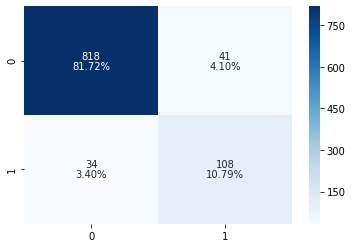

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       859
           1       0.72      0.76      0.74       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.86      0.85      1001
weighted avg       0.93      0.93      0.93      1001


0.7816901408450704
Confusion Matrix test probs: 


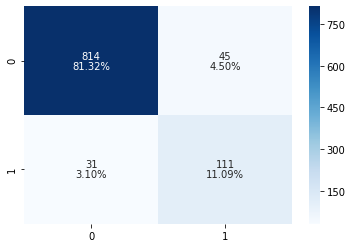

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       859
           1       0.71      0.78      0.74       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.84      0.86      0.85      1001
weighted avg       0.93      0.92      0.93      1001


0.7605633802816901
Confusion Matrix test: 


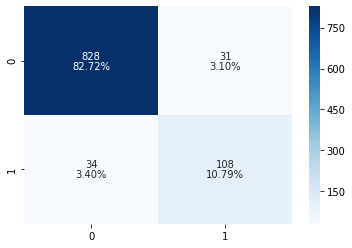

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       859
           1       0.78      0.76      0.77       142

   micro avg       0.94      0.94      0.94      1001
   macro avg       0.87      0.86      0.87      1001
weighted avg       0.93      0.94      0.93      1001


0.7816901408450704
Confusion Matrix test probs: 


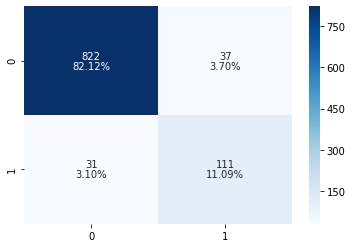

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       859
           1       0.75      0.78      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.86      0.87      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.7446808510638298
Confusion Matrix test: 


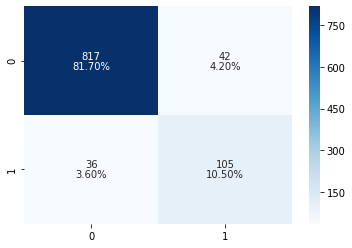

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       859
           1       0.71      0.74      0.73       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.84      0.85      0.84      1000
weighted avg       0.92      0.92      0.92      1000


0.7801418439716312
Confusion Matrix test probs: 


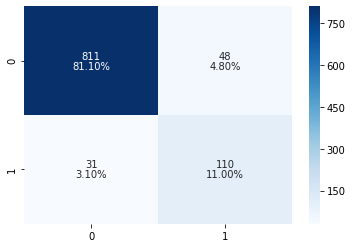

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       859
           1       0.70      0.78      0.74       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.83      0.86      0.84      1000
weighted avg       0.93      0.92      0.92      1000


0.8156028368794326
Confusion Matrix test: 


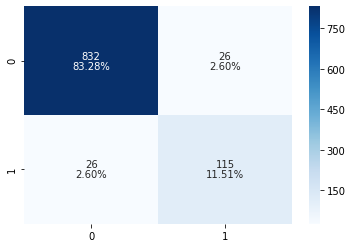

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       858
           1       0.82      0.82      0.82       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.89      0.89      0.89       999
weighted avg       0.95      0.95      0.95       999


0.8439716312056738
Confusion Matrix test probs: 


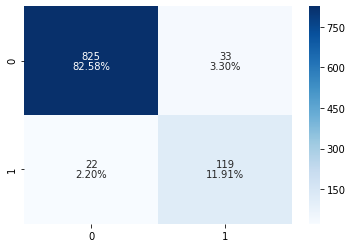

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       858
           1       0.78      0.84      0.81       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.88      0.90      0.89       999
weighted avg       0.95      0.94      0.95       999


0.7730496453900709
Confusion Matrix test: 


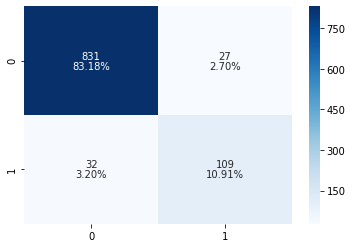

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       858
           1       0.80      0.77      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.88      0.87      0.88       999
weighted avg       0.94      0.94      0.94       999


0.8156028368794326
Confusion Matrix test probs: 


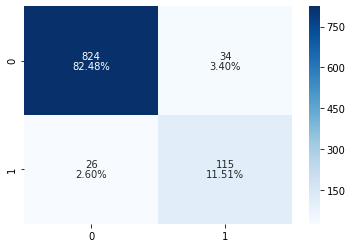

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       858
           1       0.77      0.82      0.79       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.87      0.89      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8242509146627475 0.7708920187793427 39104.0 0.8451177335126175 0.8006193187493758 46100.0


In [424]:
scores4 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    xsmote = pd.DataFrame(smoted_x, columns=Xim.columns)
    xb2.fit(xsmote, smoted_y)
    trainpred = xb2.predict(X_trains3[i])
    testpred = xb2.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in xb2.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in xb2.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests3[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests3[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

[Return to contents](#Table-of-Contents)

## Looking further into feature importance

Trying to figure out if there are trends here that can be used for business purposes

In [367]:
Xim2 = Xim.copy()

In [368]:
Xim2['probs'] = rf5.predict_proba(Xim)[:, 1]

In [369]:
Xim2['target']= y.values

In [370]:
Xim2.columns

Index(['international_plan', 'voice_mail_plan',
       'number_customer_service_calls', 'combined_charges', 'probs', 'target'],
      dtype='object')

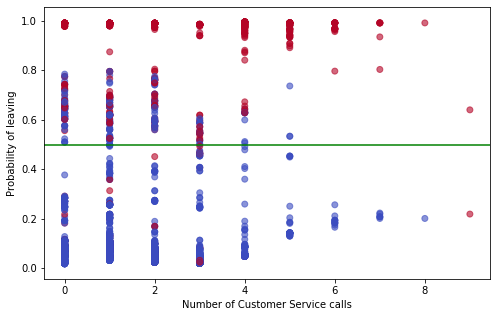

In [425]:
plt.figure(figsize=(8,5))
plt.scatter('number_customer_service_calls', 'probs', data=Xim2, c='target', cmap='coolwarm', alpha=.6)
plt.xlabel('Number of Customer Service calls')
plt.ylabel('Probability of leaving')
plt.axhline(y=0.5, color='g', linestyle='-')
plt.show()

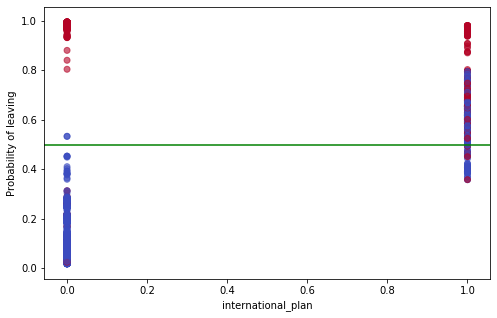

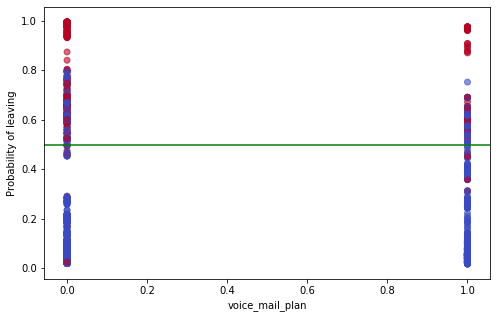

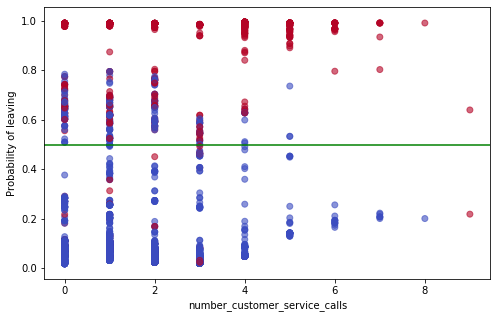

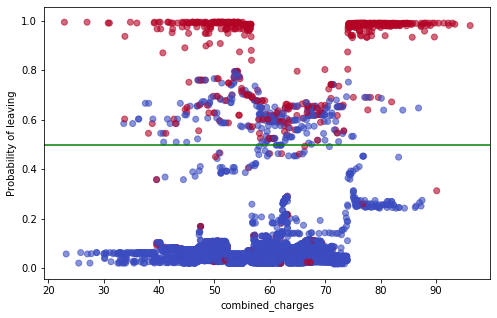

In [426]:
for col in Xim2.drop(['probs', 'target'], axis=1).columns:
    plt.figure(figsize=(8,5))
    plt.scatter(col, 'probs', data=Xim2, c='target', cmap='coolwarm', alpha=.6)
    plt.xlabel(col)
    plt.ylabel('Probability of leaving')
    plt.axhline(y=0.5, color='g', linestyle='-')
    plt.show()

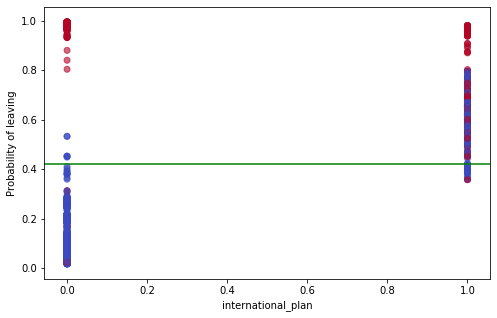

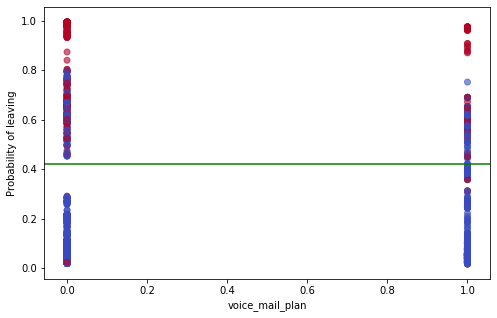

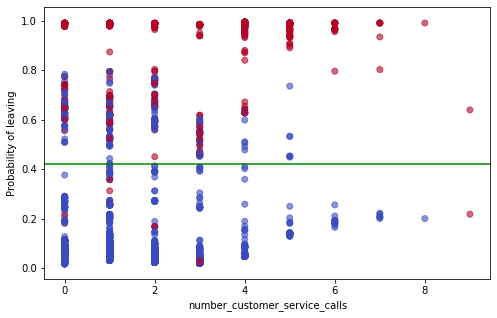

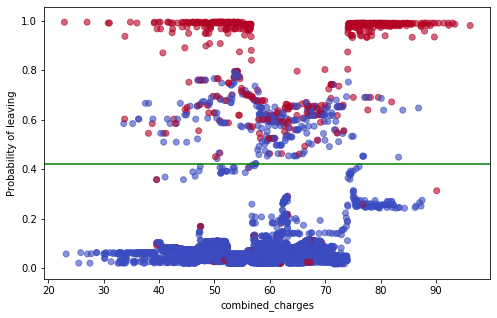

In [439]:
for col in Xim2.drop(['probs', 'target'], axis=1).columns:
    plt.figure(figsize=(8,5))
    plt.scatter(col, 'probs', data=Xim2, c='target', cmap='coolwarm', alpha=.6)
    plt.xlabel(col)
    plt.ylabel('Probability of leaving')
    plt.axhline(y=0.42, color='g', linestyle='-')
    plt.show()

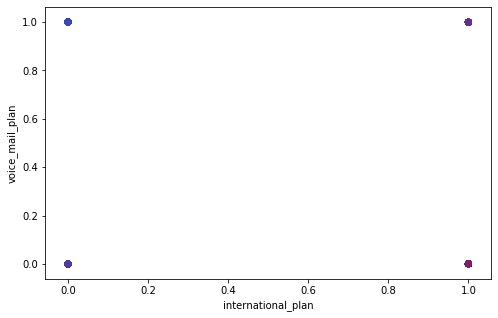

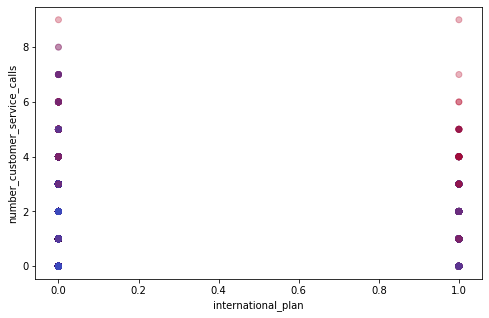

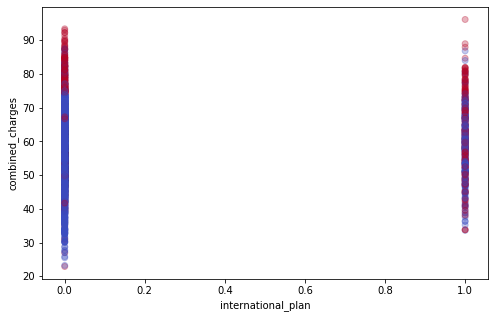

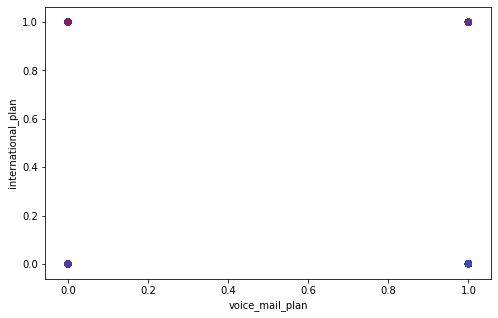

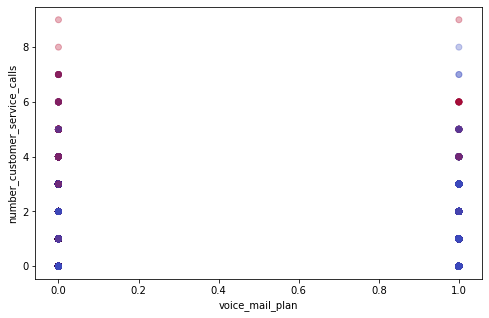

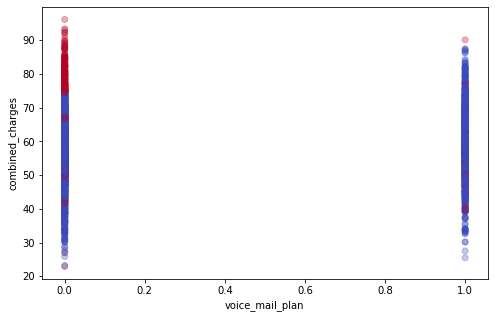

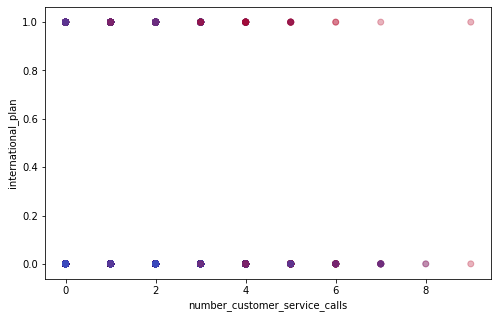

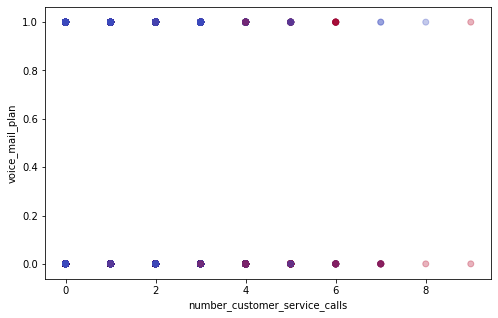

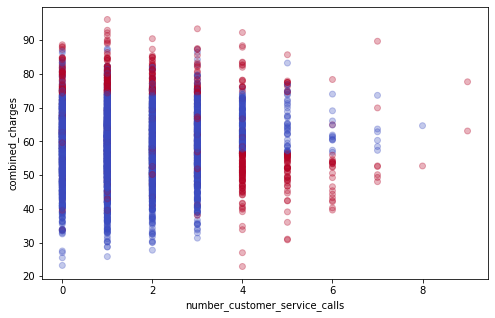

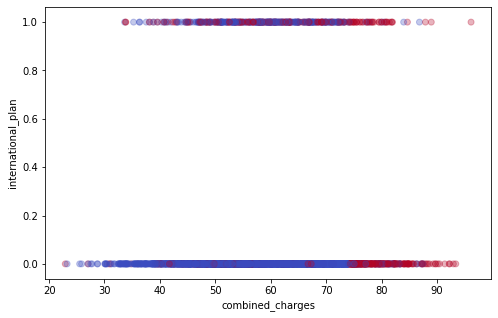

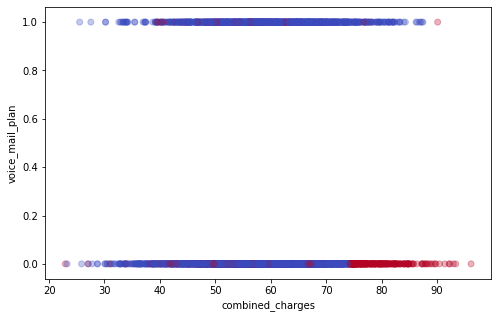

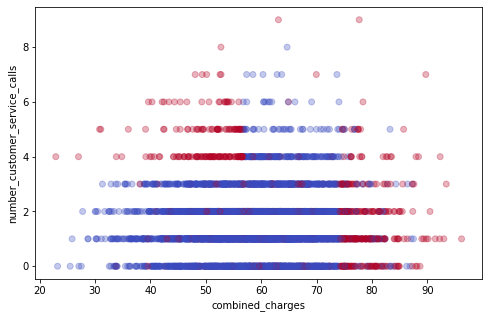

In [417]:
for col in Xim2.drop(['probs', 'target'], axis=1).columns:
    for col2 in Xim2.drop(['probs', 'target'], axis=1).columns:
        if col == col2:
            continue
        plt.figure(figsize=(8,5))
        plt.scatter(col, col2, data=Xim2, c='target', cmap='coolwarm', alpha=.3)
        plt.xlabel(col)
        plt.ylabel(col2)
        plt.show()

In [405]:
Xim2.loc[Xim2['combined_charges'] > 72].target.value_counts()

1    315
0    247
Name: target, dtype: int64

In [406]:
Xim2.loc[Xim2['combined_charges'] > 72].international_plan.value_counts()

0    494
1     68
Name: international_plan, dtype: int64

In [487]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['target'] == 1)].number_customer_service_calls.value_counts()

1    117
2     65
0     65
3     40
4     16
5      9
9      1
7      1
6      1
Name: number_customer_service_calls, dtype: int64

In [488]:
Xim2.loc[(Xim2['combined_charges'] > 72) & (Xim2['target'] == 0)].number_customer_service_calls.value_counts()

1    91
0    48
2    42
3    40
4    15
5     9
7     1
6     1
Name: number_customer_service_calls, dtype: int64

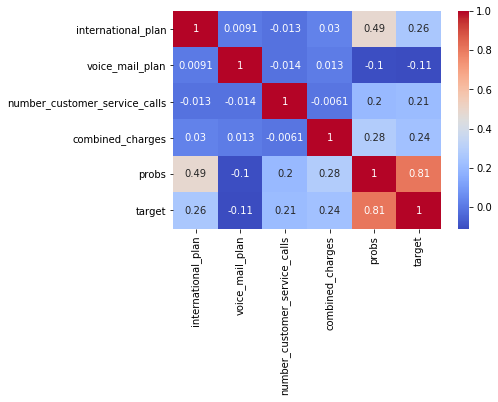

In [419]:
sns.heatmap(Xim2.corr(), cmap='coolwarm', annot=True)

In [433]:
tpred = rf5.predict(Xim)

Confusion Matrix test: 


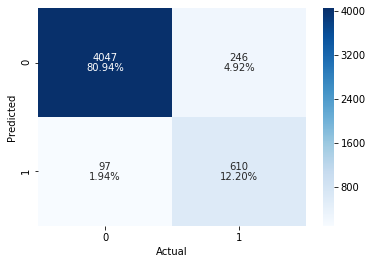

In [442]:
cm(Xim2.target.values, tpred)

In [436]:
cost_benefit(Xim2.target.values, tpred)

310720

In [464]:
g = [Xim2.target.value_counts()[0], Xim2.target.value_counts()[1]]

In [465]:
g

[4293, 707]

In [480]:
objects = ('Stay', 'Cancel')
x_pos = np.arange(len(objects))

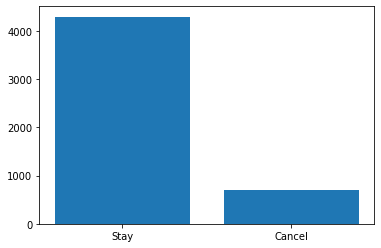

In [485]:
plt.bar([0,1], g)
plt.xticks(x_pos, objects)
plt.show()

Confusion Matrix test: 


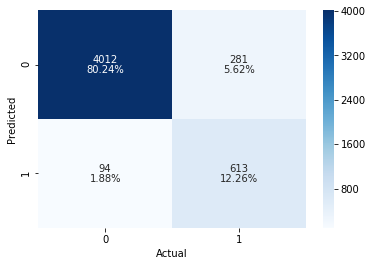

300360


In [449]:
probs = []
for a in rf5.predict_proba(Xim):
    if a[1] >=.42:
        probs.append(1)
    else:
        probs.append(0)
cm(Xim2.target.values, probs)
print(cost_benefit(Xim2.target.values, probs))

In [437]:
97/707

0.1371994342291372

In [438]:
246/(4047+246)

0.0573025856044724

In [435]:
print(classification_report(Xim2.target.values, tpred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4293
           1       0.71      0.86      0.78       707

   micro avg       0.93      0.93      0.93      5000
   macro avg       0.84      0.90      0.87      5000
weighted avg       0.94      0.93      0.93      5000



In [420]:
Ximt = Xim2.drop(['international_plan'], axis=1)

In [421]:
Xt = Ximt.drop(['target', 'probs'], axis=1)
yt = Ximt.target

In [422]:
X_trains4 = {}
X_tests4 = {}
y_trains4 = {}
y_tests4 = {}
for i, (train_index, test_index) in enumerate(skf.split(Xt, yt)):
    print(i)
    print(train_index)
    X_trains4[i] = Xt.loc[train_index]
    X_tests4[i] = Xt.loc[test_index]
    y_trains4[i] = yt[train_index]
    y_tests4[i] = yt[test_index]

0
[ 988  989  990 ... 4997 4998 4999]
1
[   0    1    2 ... 4997 4998 4999]
2
[   0    1    2 ... 4997 4998 4999]
3
[   0    1    2 ... 4997 4998 4999]
4
[   0    1    2 ... 3998 3999 4000]



0.6408450704225352
Confusion Matrix test: 


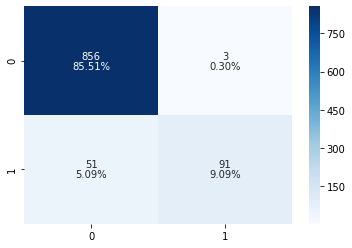

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       859
           1       0.97      0.64      0.77       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.96      0.82      0.87      1001
weighted avg       0.95      0.95      0.94      1001


0.647887323943662
Confusion Matrix test probs: 


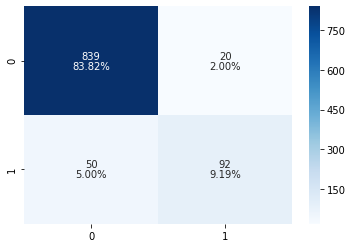

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       859
           1       0.82      0.65      0.72       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.88      0.81      0.84      1001
weighted avg       0.93      0.93      0.93      1001


0.647887323943662
Confusion Matrix test: 


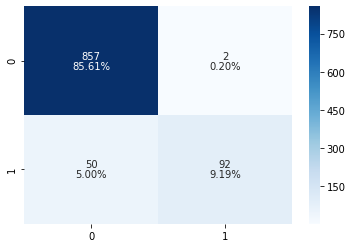

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       859
           1       0.98      0.65      0.78       142

   micro avg       0.95      0.95      0.95      1001
   macro avg       0.96      0.82      0.88      1001
weighted avg       0.95      0.95      0.94      1001


0.6549295774647887
Confusion Matrix test probs: 


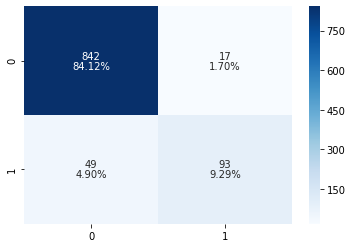

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       859
           1       0.85      0.65      0.74       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.90      0.82      0.85      1001
weighted avg       0.93      0.93      0.93      1001


0.6312056737588653
Confusion Matrix test: 


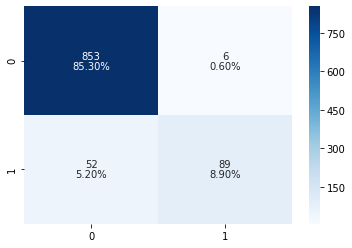

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       859
           1       0.94      0.63      0.75       141

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.94      0.81      0.86      1000
weighted avg       0.94      0.94      0.94      1000


0.6312056737588653
Confusion Matrix test probs: 


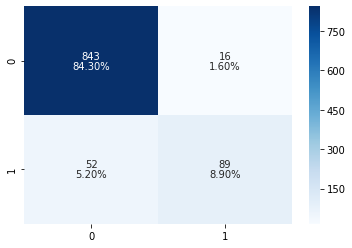

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       859
           1       0.85      0.63      0.72       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.89      0.81      0.84      1000
weighted avg       0.93      0.93      0.93      1000


0.723404255319149
Confusion Matrix test: 


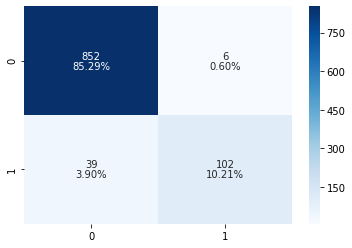

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       858
           1       0.94      0.72      0.82       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.95      0.86      0.90       999
weighted avg       0.95      0.95      0.95       999


0.723404255319149
Confusion Matrix test probs: 


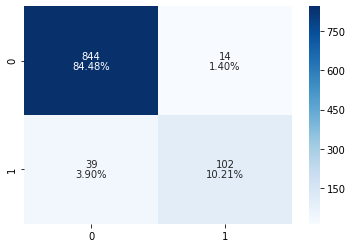

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       858
           1       0.88      0.72      0.79       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.92      0.85      0.88       999
weighted avg       0.95      0.95      0.94       999


0.6382978723404256
Confusion Matrix test: 


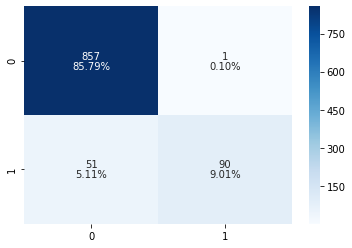

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       858
           1       0.99      0.64      0.78       141

   micro avg       0.95      0.95      0.95       999
   macro avg       0.97      0.82      0.87       999
weighted avg       0.95      0.95      0.94       999


0.6382978723404256
Confusion Matrix test probs: 


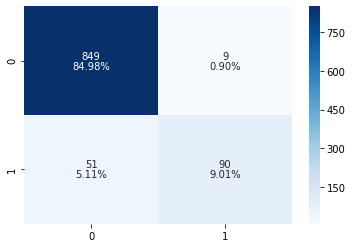

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       858
           1       0.91      0.64      0.75       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.93      0.81      0.86       999
weighted avg       0.94      0.94      0.94       999

0.6651352450045342 0.6563280391569274 15448.0 0.6810513149254198 0.6591449405653782 10600.0


In [423]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains4[i], y_trains4[i])
    rf5.fit(smoted_x, smoted_y)
    trainpred = rf5.predict(X_trains4[i])
    testpred = rf5.predict(X_tests4[i])
    train += recall_score(y_trains4[i], trainpred)
    test += recall_score(y_tests4[i], testpred)
    probs = []
    for a in rf5.predict_proba(X_tests4[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in rf5.predict_proba(X_trains4[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests4[i], testpred)
    probcb += cost_benefit(y_tests4[i], probs)
    testprobs += recall_score(y_tests4[i], probs)
    trainprobs += recall_score(y_trains4[i], probs2)
    scores2.append((i, recall_score(y_trains4[i], trainpred), recall_score(y_tests4[i], testpred), recall_score(y_trains4[i], probs2), recall_score(y_tests4[i], probs)))
    print(f'\n{recall_score(y_tests4[i], testpred)}')
    cm(y_tests4[i], testpred)
    print(classification_report(y_tests4[i], testpred))
    print(f'\n{recall_score(y_tests4[i], probs)}')
    cm(y_tests4[i], probs, t='test probs')
    print(classification_report(y_tests4[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

[Return to contents](#Table-of-Contents)

## Final Model

In [432]:
rf5 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=10, min_impurity_decrease=.001, min_samples_leaf=8)
rf5.fit(smoted_xim, smoted_yim)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


0.852112676056338
Confusion Matrix test: 


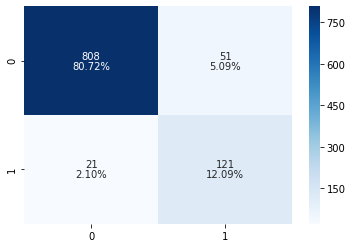

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.85      0.77       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.90      0.86      1001
weighted avg       0.94      0.93      0.93      1001


0.8661971830985915
Confusion Matrix test probs: 


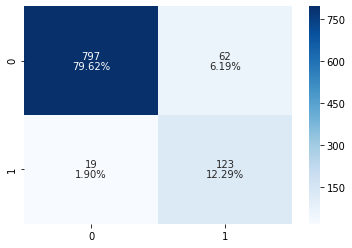

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       859
           1       0.66      0.87      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.82      0.90      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.8169014084507042
Confusion Matrix test: 


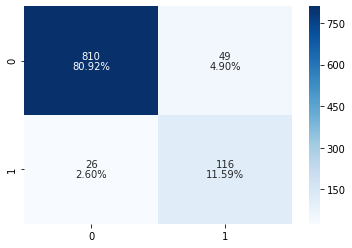

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       859
           1       0.70      0.82      0.76       142

   micro avg       0.93      0.93      0.93      1001
   macro avg       0.84      0.88      0.86      1001
weighted avg       0.93      0.93      0.93      1001


0.8169014084507042
Confusion Matrix test probs: 


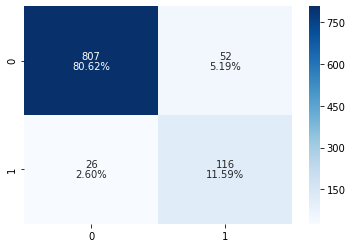

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       859
           1       0.69      0.82      0.75       142

   micro avg       0.92      0.92      0.92      1001
   macro avg       0.83      0.88      0.85      1001
weighted avg       0.93      0.92      0.92      1001


0.7943262411347518
Confusion Matrix test: 


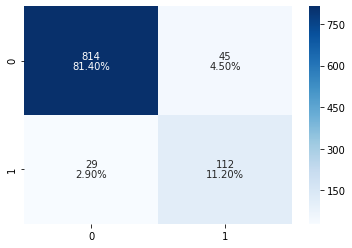

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       859
           1       0.71      0.79      0.75       141

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.84      0.87      0.85      1000
weighted avg       0.93      0.93      0.93      1000


0.8297872340425532
Confusion Matrix test probs: 


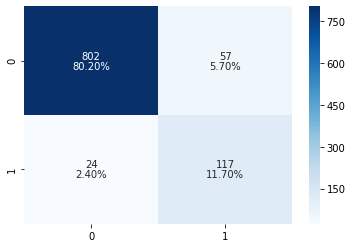

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       859
           1       0.67      0.83      0.74       141

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.82      0.88      0.85      1000
weighted avg       0.93      0.92      0.92      1000


0.8865248226950354
Confusion Matrix test: 


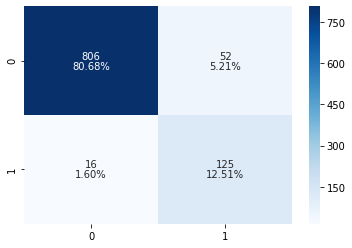

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       858
           1       0.71      0.89      0.79       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.84      0.91      0.87       999
weighted avg       0.94      0.93      0.94       999


0.8865248226950354
Confusion Matrix test probs: 


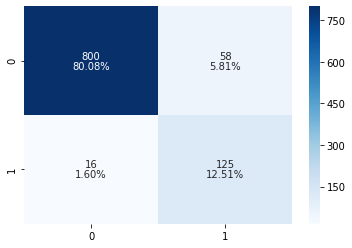

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       858
           1       0.68      0.89      0.77       141

   micro avg       0.93      0.93      0.93       999
   macro avg       0.83      0.91      0.86       999
weighted avg       0.94      0.93      0.93       999


0.8581560283687943
Confusion Matrix test: 


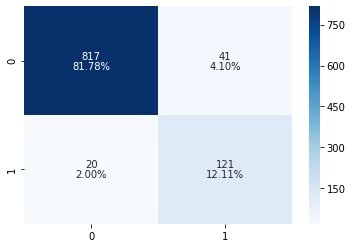

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.75      0.86      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999


0.8794326241134752
Confusion Matrix test probs: 


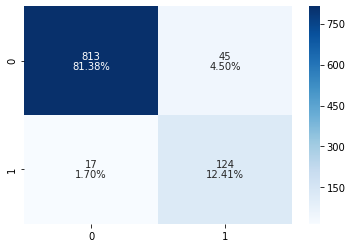

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       858
           1       0.73      0.88      0.80       141

   micro avg       0.94      0.94      0.94       999
   macro avg       0.86      0.91      0.88       999
weighted avg       0.94      0.94      0.94       999

0.8589099096281935 0.8416042353411248 55804.0 0.8649232308702587 0.8557686544800719 56964.0


In [301]:
scores2 = []
train = 0
test = 0
testprobs = 0
trainprobs = 0
cb = 0
probcb = 0
for i in range(5):
    smoted_x, smoted_y = sm.fit_sample(X_trains3[i], y_trains3[i])
    rf5.fit(smoted_x, smoted_y)
    trainpred = rf5.predict(X_trains3[i])
    testpred = rf5.predict(X_tests3[i])
    train += recall_score(y_trains3[i], trainpred)
    test += recall_score(y_tests3[i], testpred)
    probs = []
    for a in rf5.predict_proba(X_tests3[i]):
        if a[1] >=.42:
            probs.append(1)
        else:
            probs.append(0)
    probs2 = []
    for a in rf5.predict_proba(X_trains3[i]):
        if a[1] >=.42:
            probs2.append(1)
        else:
            probs2.append(0)
    cb += cost_benefit(y_tests3[i], testpred)
    probcb += cost_benefit(y_tests3[i], probs)
    testprobs += recall_score(y_tests3[i], probs)
    trainprobs += recall_score(y_trains3[i], probs2)
    scores2.append((i, recall_score(y_trains3[i], trainpred), recall_score(y_tests3[i], testpred), recall_score(y_trains3[i], probs2), recall_score(y_tests3[i], probs)))
    print(f'\n{recall_score(y_tests3[i], testpred)}')
    cm(y_tests2[i], testpred)
    print(classification_report(y_tests3[i], testpred))
    print(f'\n{recall_score(y_tests3[i], probs)}')
    cm(y_tests2[i], probs, t='test probs')
    print(classification_report(y_tests3[i], probs))
print(train/5, test/5, cb/5, trainprobs/5, testprobs/5, probcb/5)

[Return to contents](#Table-of-Contents)

## Recommendations

I would recommend a promo for customers that we predict are leaving as the cost/benefit shows that we can gain from that

[Return to contents](#Table-of-Contents)

## Further Work

Doing research to figure out the best promo amount to help retain customers

[Return to contents](#Table-of-Contents)